In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import warnings
# Ignore warnings
warnings.filterwarnings("ignore")

Importing the Required Libraries for Data Preprocessing

In [3]:
import pandas as pd
import matplotlib as plt
from scipy.stats import zscore
import seaborn as sns

In [4]:
import numpy as np
np.random.seed(42)

In [5]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

In [6]:
from sklearn.model_selection import train_test_split, cross_val_predict, cross_val_score
from sklearn.metrics import (accuracy_score, classification_report, confusion_matrix,
                             precision_score, recall_score, f1_score, roc_curve, auc, roc_auc_score)
from sklearn.preprocessing import label_binarize

In [7]:
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from xgboost import XGBClassifier

In [8]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.covariance import EllipticEnvelope
from imblearn.over_sampling import SMOTE # smote for oversampling
from sklearn.utils import shuffle # data shuffling

Reading our dataset

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
# Helper function to plot ROC curves
def plot_roc_for_classes(true_bin_labels, score, classes, title="ROC Curve"):
    fpr, tpr, _ = roc_curve(true_bin_labels, score)
    roc_auc = auc(fpr, tpr)

    # Plot the ROC
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc="lower right")
    plt.show()

# Helper function to find specificity
def specificity(cm):
    FP = cm.sum(axis=0) - np.diag(cm)
    FN = cm.sum(axis=1) - np.diag(cm)
    TP = np.diag(cm)
    TN = cm.sum() - (FP + FN + TP)
    specificity = TN/(TN+FP)
    return np.mean(specificity)

# Helper functions to print overall metrics
def print_overall_metrics(true_labels, pred_labels):
    acc = accuracy_score(true_labels, pred_labels)
    presc = precision_score(true_labels, pred_labels, average='weighted', zero_division=0)
    rec = recall_score(true_labels, pred_labels, average='weighted', zero_division=1)
    f1 = f1_score(true_labels, pred_labels, average='weighted', zero_division=1)
    tpr = rec
    # Calculate FPR correctly using roc_curve
    s = specificity(confusion_matrix(true_labels, pred_labels))
    fpr = 1 - s

    print('Accuracy:', acc)
    print('Precision:', presc)
    print('Recall (TPR):', tpr)
    print('False Positive Rate (FPR):', fpr)
    print('F1 score (F-measure):', f1)
    print('Specificity:', s)
    print("------------------------------------------------------------------------------------------------")

# Helper functions to print class-wise metrics
def get_classwise_metrics_dataframe(true_labels, pred_labels, unique_labels):
    metrics_data = []
    matrix = confusion_matrix(true_labels, pred_labels, labels=unique_labels)

    for i, label in enumerate(unique_labels):
        tp = matrix[i, i]
        fp = np.sum(matrix[:, i]) - tp
        fn = np.sum(matrix[i, :]) - tp
        tn = np.sum(matrix) - tp - fp - fn

        tpr = tp / (tp + fn) if (tp + fn) != 0 else 0
        fpr = fp / (fp + tn) if (fp + tn) != 0 else 0
        precision = tp / (tp + fp) if (tp + fp) != 0 else 0
        recall = tpr
        f_measure = (2 * precision * recall) / (precision + recall) if (precision + recall) != 0 else 0
        accuracy = (tp + tn) / (tp + tn + fp + fn)

        metrics_data.append([label, accuracy, precision, recall, fpr, f_measure, tp, fp, tn, fn])

    df = pd.DataFrame(metrics_data, columns=['Class', 'Accuracy', 'Precision', 'Recall (TPR)', 'FPR', 'F1 Score (F-measure)', 'TP', 'FP', 'TN', 'FN'])

    return df

# Helper function to plot confusion matrix
def plot_confusion_matrix(matrix, dataset_name, unique_labels):
    plt.figure(figsize=(8,6))
    sns.heatmap(matrix, annot=True, fmt='d', cmap='Blues')
    tick_marks = np.arange(len(unique_labels))
    plt.xticks(tick_marks + 0.5, unique_labels, rotation=45)  # +0.5 to center the label
    plt.yticks(tick_marks + 0.5, unique_labels)  # +0.5 to center the label
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(f'Confusion Matrix')
    plt.show()

In [10]:
def runclassifier(model, X_train, y_train, X_test, y_test):

    labels_series = y_train['TenYearCHD']
    unique_labels = sorted(labels_series.unique())

    # Binarize the labels for ROC curve generation
    y_train_bin = label_binarize(y_train, classes=unique_labels)
    y_test_bin = label_binarize(y_test, classes=unique_labels)

    model.fit(X_train, y_train)
    y_train_pred = cross_val_predict(model, X_train, y_train, cv=10)
    y_test_pred = model.predict(X_test)

    # Overall metrics for training set
    print("Overall Metrics for Training set:")
    print("------------------------------------------------------------------------------------------------")
    print_overall_metrics(y_train, y_train_pred)

    # Display metrics in tabular format for each class
    classwise_df_train = get_classwise_metrics_dataframe(y_train, y_train_pred, unique_labels)
    print("\nClasswise Metrics for Training Set:")
    display(classwise_df_train)

    print("------------------------------------------------------------------------------------------------")
    print("Confusion Matrix for Train Set")
    print("------------------------------------------------------------------------------------------------")
    plot_confusion_matrix(confusion_matrix(y_train, y_train_pred), 'Training Set', unique_labels)
    print("------------------------------------------------------------------------------------------------")
    #print("ROC Curve for Train Set")
    #print("------------------------------------------------------------------------------------------------")
    #plot_roc_for_classes(y_train_bin, model.predict_proba(X_train)[:, 1], unique_labels, title="ROC Curve (Training Data)")
    #print("------------------------------------------------------------------------------------------------")
    # Overall metrics for test set
    print("\nOverall Metrics for Test set:")
    print("------------------------------------------------------------------------------------------------")
    print_overall_metrics(y_test, y_test_pred)

    # Display metrics in tabular format for each class
    classwise_df_test = get_classwise_metrics_dataframe(y_test, y_test_pred, unique_labels)
    print("\nClasswise Metrics for Test Set:")
    display(classwise_df_test)

    print("------------------------------------------------------------------------------------------------")
    print("Confusion Matrix for Test Set")
    print("------------------------------------------------------------------------------------------------")
    plot_confusion_matrix(confusion_matrix(y_test, y_test_pred), 'Test Set', unique_labels)
   # print("------------------------------------------------------------------------------------------------")
    #print("ROC Curve for Test Set")
    #print("------------------------------------------------------------------------------------------------")
    #plot_roc_for_classes(y_test_bin, model.predict_proba(X_test)[:, 1], unique_labels, title="ROC Curve (Test Data)")

     # Create metrics dictionary
    metrics_dict = {
        "Model": model.__class__.__name__,
        "Training Metrics": {
            "Accuracy": accuracy_score(y_train, y_train_pred),
            "Precision": precision_score(y_train, y_train_pred, average='weighted',zero_division=0),
            "Recall": recall_score(y_train, y_train_pred, average='weighted'),
            "F1 score": f1_score(y_train, y_train_pred, average='weighted'),
            "TP": np.diag(confusion_matrix(y_train, y_train_pred)),
            "FP": confusion_matrix(y_train, y_train_pred).sum(axis=0) - np.diag(confusion_matrix(y_train, y_train_pred)),
            "TN": confusion_matrix(y_train, y_train_pred).sum() - (confusion_matrix(y_train, y_train_pred).sum(axis=1) + confusion_matrix(y_train, y_train_pred).sum(axis=0)- np.diag(confusion_matrix(y_train, y_train_pred))),
            "FN": confusion_matrix(y_train, y_train_pred).sum(axis=1)-np.diag(confusion_matrix(y_train, y_train_pred)),
            "Sensitivity (TPR)": recall_score(y_train, y_train_pred, average='weighted'),
            "Specificity": specificity(confusion_matrix(y_train, y_train_pred)),
            "FPR": 1 - specificity(confusion_matrix(y_train, y_train_pred))
        },
        "Test Metrics": {
            "Accuracy": accuracy_score(y_test, y_test_pred),
            "Precision": precision_score(y_test, y_test_pred, average='weighted',zero_division=0),
            "Recall": recall_score(y_test, y_test_pred,average='weighted'),
            "F1 score": f1_score(y_test, y_test_pred, average='weighted'),
            "TP": np.diag(confusion_matrix(y_test, y_test_pred)),
            "FP": confusion_matrix(y_test, y_test_pred).sum(axis=0) - np.diag(confusion_matrix(y_test, y_test_pred)),
            "TN": confusion_matrix(y_test, y_test_pred).sum() - (confusion_matrix(y_test, y_test_pred).sum(axis=1) + confusion_matrix(y_test, y_test_pred).sum(axis=0)- np.diag(confusion_matrix(y_test, y_test_pred))),
            "FN": confusion_matrix(y_test, y_test_pred).sum(axis=1)-np.diag(confusion_matrix(y_test, y_test_pred)),
            #"TP": confusion_matrix(y_test, y_test_pred).sum(axis=1),
            #"FP": confusion_matrix(y_test, y_test_pred).sum(axis=0) - np.diag(confusion_matrix(y_test, y_test_pred)),
            #"TN": confusion_matrix(y_test, y_test_pred).sum() - (confusion_matrix(y_test, y_test_pred).sum(axis=1) + confusion_matrix(y_test, y_test_pred).sum(axis=0)),
            #"FN": np.diag(confusion_matrix(y_test, y_test_pred)),
            "Sensitivity (TPR)": recall_score(y_test, y_test_pred, average='weighted'),
            "Specificity": specificity(confusion_matrix(y_test, y_test_pred)),
            "FPR": 1 - specificity(confusion_matrix(y_test, y_test_pred))
        }
    }

    return metrics_dict

In [11]:
df= pd.read_csv("/content/drive/MyDrive/Kaggle/CHD_preprocessed.csv")

In [12]:
df.head()

,male,age,education,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
0,1,39,1,0,0.0,0.0,0,0,0,195.0,106.0,70.0,26.97,80.0,77.0,0
1,0,46,0,0,0.0,0.0,0,0,0,250.0,121.0,81.0,28.73,95.0,76.0,0
2,1,48,0,1,20.0,0.0,0,0,0,245.0,127.5,80.0,25.34,75.0,70.0,0
3,0,61,1,1,30.0,0.0,0,1,0,225.0,150.0,95.0,28.58,65.0,103.0,1
4,0,46,1,1,23.0,0.0,0,0,0,285.0,130.0,84.0,23.10,85.0,85.0,0


In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4133 entries, 0 to 4132
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   male             4133 non-null   int64  
 1   age              4133 non-null   int64  
 2   education        4133 non-null   int64  
 3   currentSmoker    4133 non-null   int64  
 4   cigsPerDay       4133 non-null   float64
 5   BPMeds           4133 non-null   float64
 6   prevalentStroke  4133 non-null   int64  
 7   prevalentHyp     4133 non-null   int64  
 8   diabetes         4133 non-null   int64  
 9   totChol          4133 non-null   float64
 10  sysBP            4133 non-null   float64
 11  diaBP            4133 non-null   float64
 12  BMI              4133 non-null   float64
 13  heartRate        4133 non-null   float64
 14  glucose          4133 non-null   float64
 15  TenYearCHD       4133 non-null   int64  
dtypes: float64(8), int64(8)
memory usage: 516.8 KB


### Basic Data Preprocessing before generating additional records

Missing Values

In [14]:
# checking if there are any missing values in the dataset
missing_count = df.isnull().sum()
print('Number of missing values in the dataset: ' , missing_count.sum())

Number of missing values in the dataset:  0


Checking for Duplicates

In [15]:
duplicate_records = df.duplicated()
print('Number of duplicate values in the dataset: ', duplicate_records.sum())
print(duplicate_records)

Number of duplicate values in the dataset:  0
0       False
1       False
2       False
3       False
4       False
        ...  
4128    False
4129    False
4130    False
4131    False
4132    False
Length: 4133, dtype: bool


In [ ]:
df.nunique()

male                  2
age                  39
education             2
currentSmoker         2
cigsPerDay           33
BPMeds                2
prevalentStroke       2
prevalentHyp          2
diabetes              2
totChol             247
sysBP               234
diaBP               146
BMI                1355
heartRate            73
glucose             140
TenYearCHD            2
dtype: int64

Data Manipulation

In [16]:
df.rename(columns={'male': 'gender'}, inplace=True)

In [17]:
df

,gender,age,education,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
0,1,39,1,0,0.0,0.0,0,0,0,195.0,106.0,70.0,26.97,80.0,77.0,0
1,0,46,0,0,0.0,0.0,0,0,0,250.0,121.0,81.0,28.73,95.0,76.0,0
2,1,48,0,1,20.0,0.0,0,0,0,245.0,127.5,80.0,25.34,75.0,70.0,0
3,0,61,1,1,30.0,0.0,0,1,0,225.0,150.0,95.0,28.58,65.0,103.0,1
4,0,46,1,1,23.0,0.0,0,0,0,285.0,130.0,84.0,23.10,85.0,85.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4128,1,50,0,1,1.0,0.0,0,1,0,313.0,179.0,92.0,25.97,66.0,86.0,1
4129,1,51,1,1,43.0,0.0,0,0,0,207.0,126.5,80.0,19.71,65.0,68.0,0
4130,0,48,0,1,20.0,0.0,0,0,0,248.0,131.0,72.0,22.00,84.0,86.0,0
4131,0,44,0,1,15.0,0.0,0,0,0,210.0,126.5,87.0,19.16,86.0,82.0,0


In [18]:
def detect_outliers_iqr(df):
  threshold = 3
  q1 = np.percentile(df, 25) # calculate q1 (1/4) quartile
  q3 = np.percentile(df, 75) # calculate q3 (3/4) quartile
  iqr = q3 - q1
  outliers = df[(df < q1 - threshold * iqr) | (df > q3 + threshold * iqr)] # calculate outliers formula
  print("Number of Outliers:", outliers.sum())
  return outliers

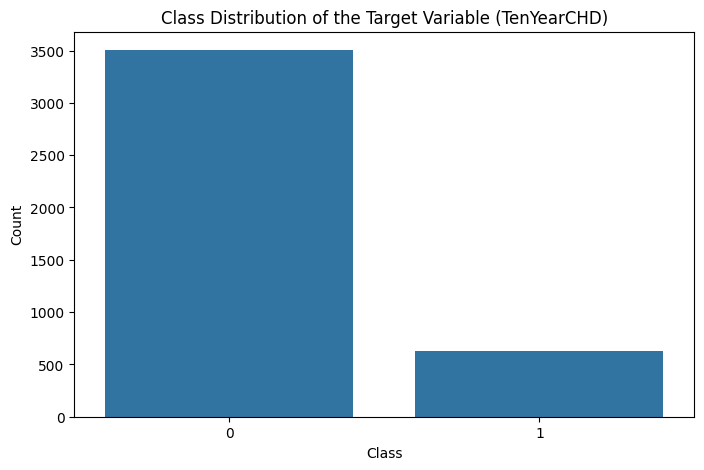

In [19]:
# Checking if the data is imbalanced
target_column = 'TenYearCHD'
class_counts = df[target_column].value_counts()

# Plotting the class distribution
plt.figure(figsize=(8, 5))
sns.barplot(x=class_counts.index, y=class_counts.values)
plt.title('Class Distribution of the Target Variable (TenYearCHD)')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

In [23]:
from sklearn.utils import resample

# Separate the minority and majority classes
majority_class = df[df[target_column] == 0]
minority_class = df[df[target_column] == 1]

In [26]:
# sample the minority
data_upsampled = resample(minority_class,
                                   replace=True,     # sample with replacement
                                   n_samples=len(majority_class),    # to match majority class
                                   random_state=42) # reproducible results

# Combine majority class with upsampled minority class
df_upsampled = pd.concat([majority_class, data_upsampled])

# Display new class counts
updated_class_counts = df_upsampled[target_column].value_counts()

In [22]:
updated_class_counts

TenYearCHD
0    3505
1    3505
Name: count, dtype: int64

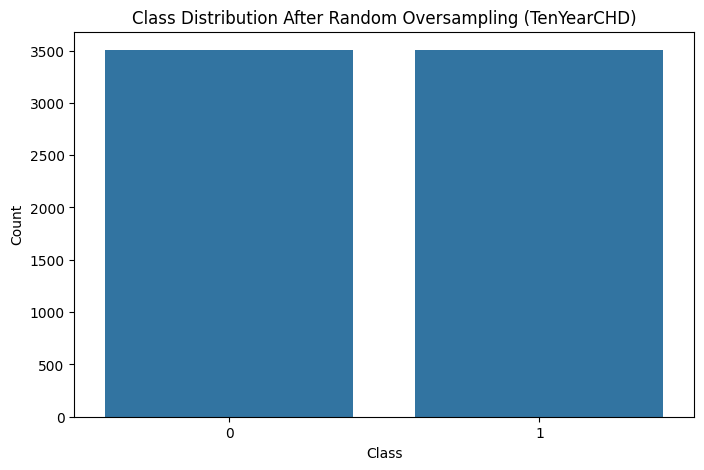

In [27]:
# Plotting the class distribution after resampling
plt.figure(figsize=(8, 5))
sns.barplot(x=updated_class_counts.index, y=updated_class_counts.values)
plt.title('Class Distribution After Random Oversampling (TenYearCHD)')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

In [28]:
# Splitting the dataset into features and target variable
X = df_upsampled.drop('TenYearCHD', axis=1)
y = df_upsampled['TenYearCHD']

# Splitting the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train_shuffled, y_train_shuffled = shuffle(X_train, y_train, random_state=42)

In [29]:
y_train_shuffled_df = pd.DataFrame(y_train_shuffled)
y_test_df = pd.DataFrame(y_test)

In [30]:
y_train_shuffled_df.columns = ['TenYearCHD']
y_test_df.columns = ['TenYearCHD']

Gaussian Naive Bayes

Gaussian Naive Bayes performance for Training and Testing dataset with 10-fold crossvalidation
------------------------------------------------------------------------------------------------
Overall Metrics for Training set:
------------------------------------------------------------------------------------------------
Accuracy: 0.5939728958630528
Precision: 0.651372521394287
Recall (TPR): 0.5939728958630528
False Positive Rate (FPR): 0.4027308558021384
F1 score (F-measure): 0.5548241751682214
Specificity: 0.5972691441978616
------------------------------------------------------------------------------------------------

Classwise Metrics for Training Set:


,Class,Accuracy,Precision,Recall (TPR),FPR,F1 Score (F-measure),TP,FP,TN,FN
0,0,0.593973,0.555481,0.895420,0.700882,0.685628,2483,1987,848,290
1,1,0.593973,0.745167,0.299118,0.104580,0.426881,848,290,2483,1987


------------------------------------------------------------------------------------------------
Confusion Matrix for Train Set
------------------------------------------------------------------------------------------------


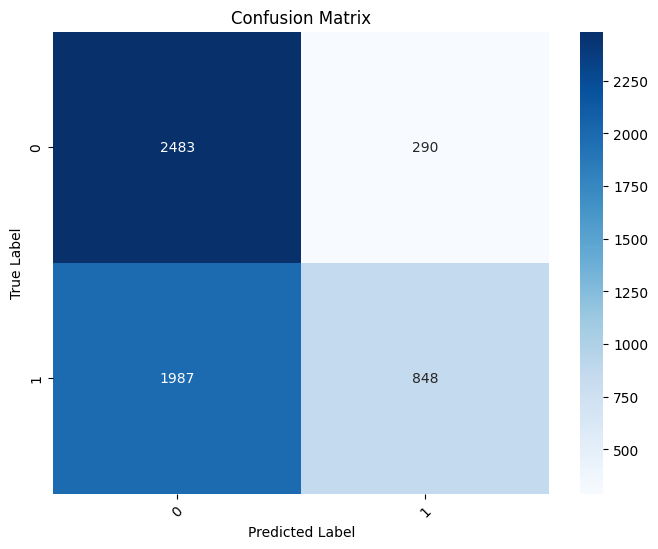

------------------------------------------------------------------------------------------------

Overall Metrics for Test set:
------------------------------------------------------------------------------------------------
Accuracy: 0.6162624821683309
Precision: 0.6592553536870036
Recall (TPR): 0.6162624821683309
False Positive Rate (FPR): 0.39694152189870324
F1 score (F-measure): 0.5770378860536444
Specificity: 0.6030584781012968
------------------------------------------------------------------------------------------------

Classwise Metrics for Test Set:


,Class,Accuracy,Precision,Recall (TPR),FPR,F1 Score (F-measure),TP,FP,TN,FN
0,0,0.616262,0.586146,0.901639,0.695522,0.710441,660,466,204,72
1,1,0.616262,0.739130,0.304478,0.098361,0.431290,204,72,660,466


------------------------------------------------------------------------------------------------
Confusion Matrix for Test Set
------------------------------------------------------------------------------------------------


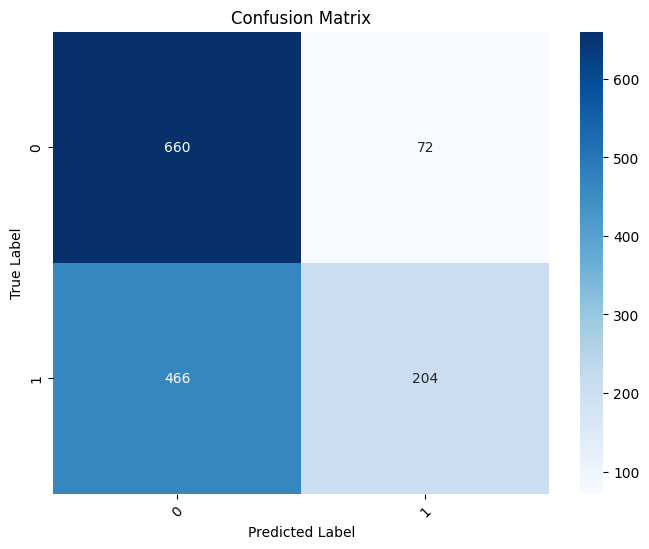

In [ ]:
print("Gaussian Naive Bayes performance for Training and Testing dataset with 10-fold crossvalidation")
print("------------------------------------------------------------------------------------------------")
model = GaussianNB()
gb_result_1 = runclassifier(model,X_train_shuffled, y_train_shuffled_df, X_test, y_test_df)

Logistic Regression

Logistic Regression performance for Training and Testing dataset with 10-fold crossvalidation
------------------------------------------------------------------------------------------------
Overall Metrics for Training set:
------------------------------------------------------------------------------------------------
Accuracy: 0.6601283880171184
Precision: 0.6601374957455094
Recall (TPR): 0.6601283880171184
False Positive Rate (FPR): 0.34005511702350266
F1 score (F-measure): 0.6600240640232581
Specificity: 0.6599448829764973
------------------------------------------------------------------------------------------------

Classwise Metrics for Training Set:


,Class,Accuracy,Precision,Recall (TPR),FPR,F1 Score (F-measure),TP,FP,TN,FN
0,0,0.660128,0.660496,0.643347,0.323457,0.651809,1784,917,1918,989
1,1,0.660128,0.659787,0.676543,0.356653,0.668060,1918,989,1784,917


------------------------------------------------------------------------------------------------
Confusion Matrix for Train Set
------------------------------------------------------------------------------------------------


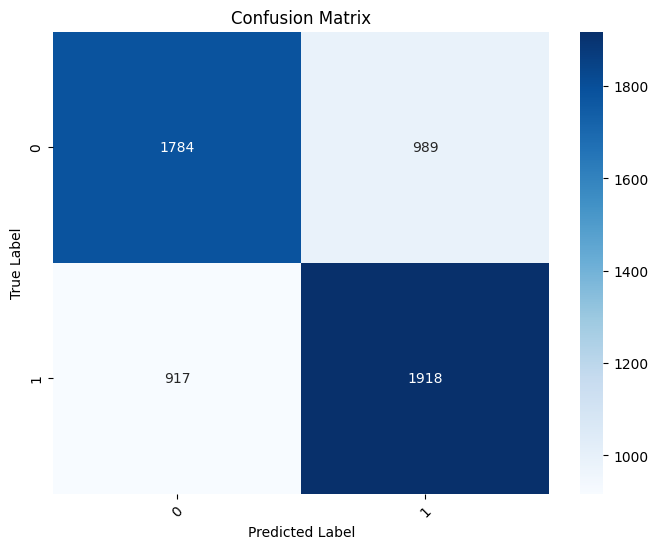

------------------------------------------------------------------------------------------------

Overall Metrics for Test set:
------------------------------------------------------------------------------------------------
Accuracy: 0.6355206847360912
Precision: 0.6357501876957
Recall (TPR): 0.6355206847360912
False Positive Rate (FPR): 0.36490906125112144
F1 score (F-measure): 0.6356092607888022
Specificity: 0.6350909387488786
------------------------------------------------------------------------------------------------

Classwise Metrics for Test Set:


,Class,Accuracy,Precision,Recall (TPR),FPR,F1 Score (F-measure),TP,FP,TN,FN
0,0,0.635521,0.652835,0.644809,0.374627,0.648797,472,251,419,260
1,1,0.635521,0.617084,0.625373,0.355191,0.621201,419,260,472,251


------------------------------------------------------------------------------------------------
Confusion Matrix for Test Set
------------------------------------------------------------------------------------------------


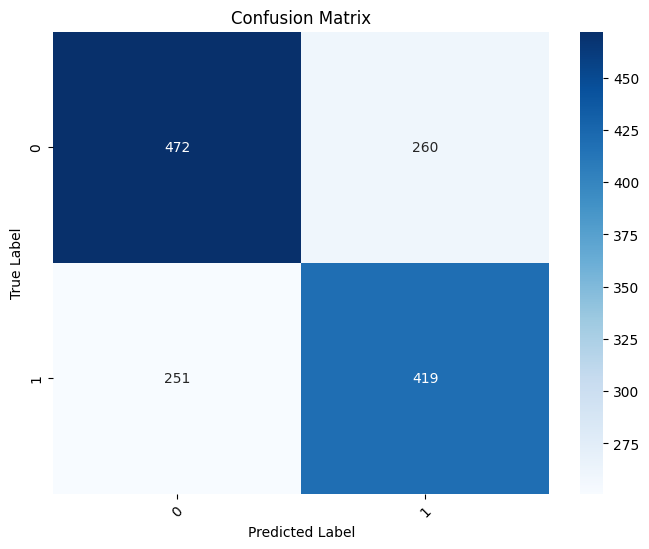

In [ ]:
print("Logistic Regression performance for Training and Testing dataset with 10-fold crossvalidation")
print("------------------------------------------------------------------------------------------------")
model = LogisticRegression()
lr_result_1 = runclassifier(model,X_train_shuffled, y_train_shuffled_df, X_test, y_test_df)

Support Vector Machine

Support Vector Machine performance for Training and Testing dataset with 10-fold crossvalidation
------------------------------------------------------------------------------------------------
Overall Metrics for Training set:
------------------------------------------------------------------------------------------------
Accuracy: 0.6631597717546363
Precision: 0.6632552518451528
Recall (TPR): 0.6631597717546361
False Positive Rate (FPR): 0.33679662352579776
F1 score (F-measure): 0.6631685222972628
Specificity: 0.6632033764742022
------------------------------------------------------------------------------------------------

Classwise Metrics for Training Set:


,Class,Accuracy,Precision,Recall (TPR),FPR,F1 Score (F-measure),TP,FP,TN,FN
0,0,0.66316,0.656960,0.667147,0.340741,0.662015,1850,966,1869,923
1,1,0.66316,0.669413,0.659259,0.332853,0.664297,1869,923,1850,966


------------------------------------------------------------------------------------------------
Confusion Matrix for Train Set
------------------------------------------------------------------------------------------------


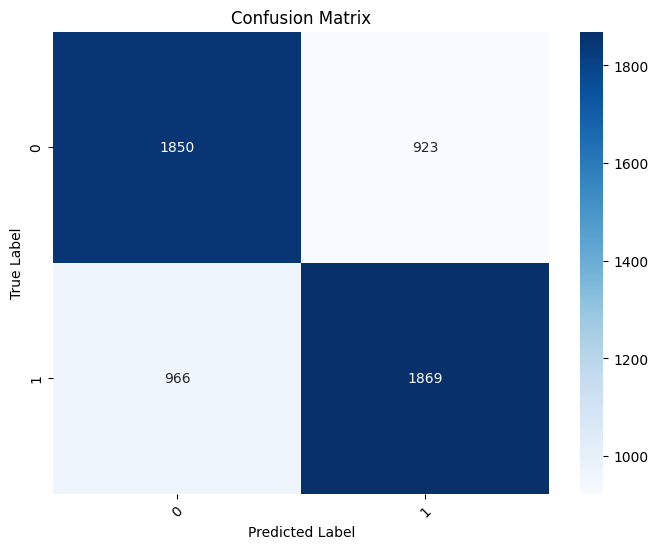

------------------------------------------------------------------------------------------------

Overall Metrics for Test set:
------------------------------------------------------------------------------------------------
Accuracy: 0.6526390870185449
Precision: 0.6525005075047241
Recall (TPR): 0.6526390870185449
False Positive Rate (FPR): 0.34826278443846337
F1 score (F-measure): 0.6525535241657464
Specificity: 0.6517372155615366
------------------------------------------------------------------------------------------------

Classwise Metrics for Test Set:


,Class,Accuracy,Precision,Recall (TPR),FPR,F1 Score (F-measure),TP,FP,TN,FN
0,0,0.652639,0.665765,0.672131,0.368657,0.668933,492,247,423,240
1,1,0.652639,0.638009,0.631343,0.327869,0.634659,423,240,492,247


------------------------------------------------------------------------------------------------
Confusion Matrix for Test Set
------------------------------------------------------------------------------------------------


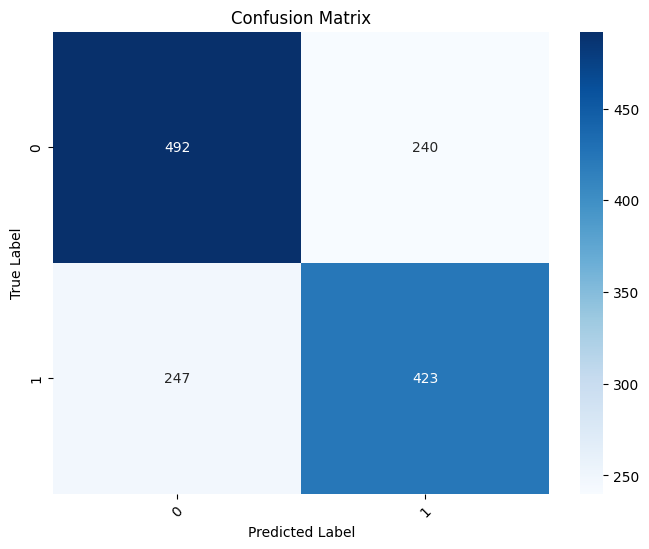

In [ ]:
print("Support Vector Machine performance for Training and Testing dataset with 10-fold crossvalidation")
print("------------------------------------------------------------------------------------------------")
model = SVC(probability=True)
svc_result_1 = runclassifier(model,X_train_shuffled, y_train_shuffled_df, X_test, y_test_df)

RandomForest

RandomForest Machine performance for Training and Testing dataset with 10-fold crossvalidation
------------------------------------------------------------------------------------------------
Overall Metrics for Training set:
------------------------------------------------------------------------------------------------
Accuracy: 0.9621968616262482
Precision: 0.9628935334707249
Recall (TPR): 0.9621968616262482
False Positive Rate (FPR): 0.038024640476858274
F1 score (F-measure): 0.9621740979866258
Specificity: 0.9619753595231417
------------------------------------------------------------------------------------------------

Classwise Metrics for Training Set:


,Class,Accuracy,Precision,Recall (TPR),FPR,F1 Score (F-measure),TP,FP,TN,FN
0,0,0.962197,0.980849,0.941940,0.017989,0.961001,2612,51,2784,161
1,1,0.962197,0.945331,0.982011,0.058060,0.963322,2784,161,2612,51


------------------------------------------------------------------------------------------------
Confusion Matrix for Train Set
------------------------------------------------------------------------------------------------


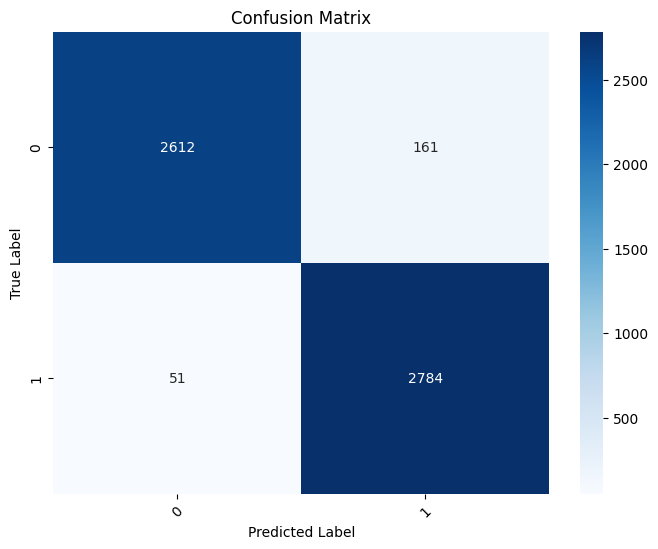

------------------------------------------------------------------------------------------------

Overall Metrics for Test set:
------------------------------------------------------------------------------------------------
Accuracy: 0.9643366619115549
Precision: 0.9649349935369455
Recall (TPR): 0.9643366619115549
False Positive Rate (FPR): 0.03497471658102924
F1 score (F-measure): 0.9643532211350077
Specificity: 0.9650252834189708
------------------------------------------------------------------------------------------------

Classwise Metrics for Test Set:


,Class,Accuracy,Precision,Recall (TPR),FPR,F1 Score (F-measure),TP,FP,TN,FN
0,0,0.964337,0.981638,0.949454,0.019403,0.965278,695,13,657,37
1,1,0.964337,0.946686,0.980597,0.050546,0.963343,657,37,695,13


------------------------------------------------------------------------------------------------
Confusion Matrix for Test Set
------------------------------------------------------------------------------------------------


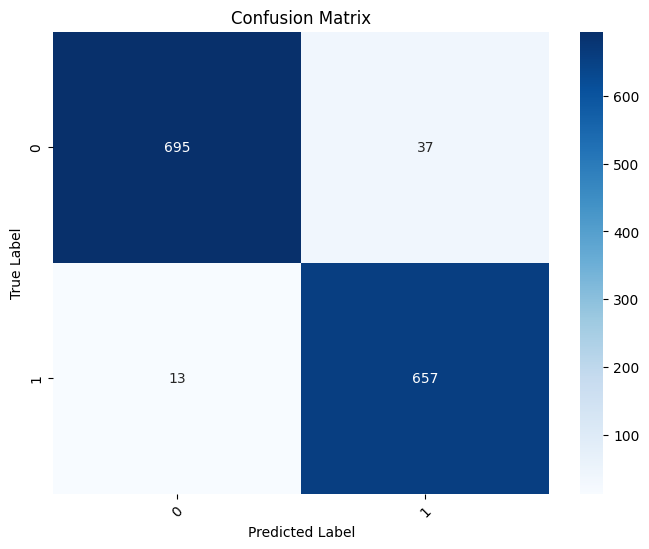

In [ ]:
print("RandomForest Machine performance for Training and Testing dataset with 10-fold crossvalidation")
print("------------------------------------------------------------------------------------------------")
model = RandomForestClassifier()
rf_result_1 = runclassifier(model,X_train_shuffled, y_train_shuffled_df, X_test, y_test_df)

DecisionTree

Decision Tree performance for Training and Testing dataset with 10-fold crossvalidation
------------------------------------------------------------------------------------------------
Overall Metrics for Training set:
------------------------------------------------------------------------------------------------
Accuracy: 0.9037089871611983
Precision: 0.9142459064038247
Recall (TPR): 0.9037089871611983
False Positive Rate (FPR): 0.09719002398410992
F1 score (F-measure): 0.9029976305237336
Specificity: 0.9028099760158901
------------------------------------------------------------------------------------------------

Classwise Metrics for Training Set:


,Class,Accuracy,Precision,Recall (TPR),FPR,F1 Score (F-measure),TP,FP,TN,FN
0,0,0.903709,0.980628,0.821493,0.015873,0.894035,2278,45,2790,495
1,1,0.903709,0.849315,0.984127,0.178507,0.911765,2790,495,2278,45


------------------------------------------------------------------------------------------------
Confusion Matrix for Train Set
------------------------------------------------------------------------------------------------


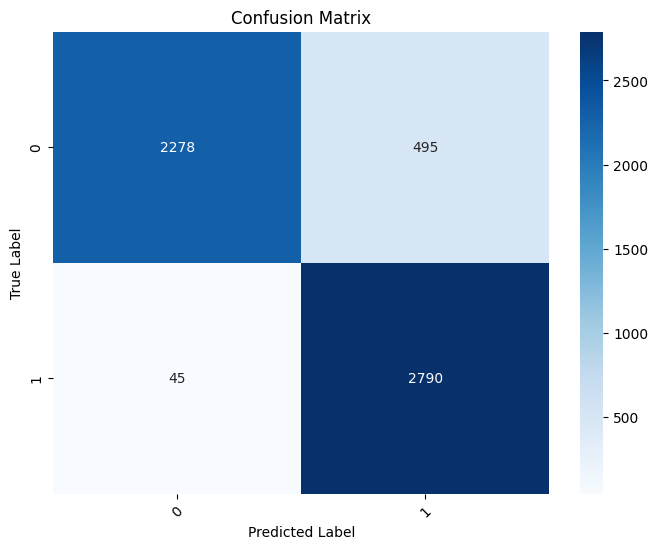

------------------------------------------------------------------------------------------------

Overall Metrics for Test set:
------------------------------------------------------------------------------------------------
Accuracy: 0.9029957203994294
Precision: 0.9137283298690291
Recall (TPR): 0.9029957203994294
False Positive Rate (FPR): 0.09371788597993636
F1 score (F-measure): 0.9027348419823302
Specificity: 0.9062821140200636
------------------------------------------------------------------------------------------------

Classwise Metrics for Test Set:


,Class,Accuracy,Precision,Recall (TPR),FPR,F1 Score (F-measure),TP,FP,TN,FN
0,0,0.902996,0.979100,0.831967,0.019403,0.899557,609,13,657,123
1,1,0.902996,0.842308,0.980597,0.168033,0.906207,657,123,609,13


------------------------------------------------------------------------------------------------
Confusion Matrix for Test Set
------------------------------------------------------------------------------------------------


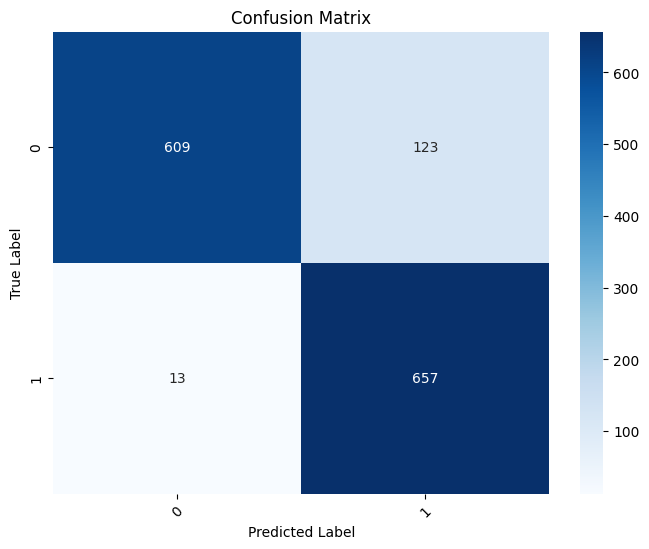

In [ ]:
print("Decision Tree performance for Training and Testing dataset with 10-fold crossvalidation")
print("------------------------------------------------------------------------------------------------")
model = DecisionTreeClassifier()
dt_result_1 = runclassifier(model,X_train_shuffled, y_train_shuffled_df, X_test, y_test_df)

ExtraTree

Extra Tree performance for Training and Testing dataset with 10-fold crossvalidation
------------------------------------------------------------------------------------------------
Overall Metrics for Training set:
------------------------------------------------------------------------------------------------
Accuracy: 0.9037089871611983
Precision: 0.9144410747519016
Recall (TPR): 0.9037089871611983
False Positive Rate (FPR): 0.09719791056490179
F1 score (F-measure): 0.9029856051039303
Specificity: 0.9028020894350982
------------------------------------------------------------------------------------------------

Classwise Metrics for Training Set:


,Class,Accuracy,Precision,Recall (TPR),FPR,F1 Score (F-measure),TP,FP,TN,FN
0,0,0.903709,0.981458,0.820772,0.015168,0.893951,2276,43,2792,497
1,1,0.903709,0.848890,0.984832,0.179228,0.911822,2792,497,2276,43


------------------------------------------------------------------------------------------------
Confusion Matrix for Train Set
------------------------------------------------------------------------------------------------


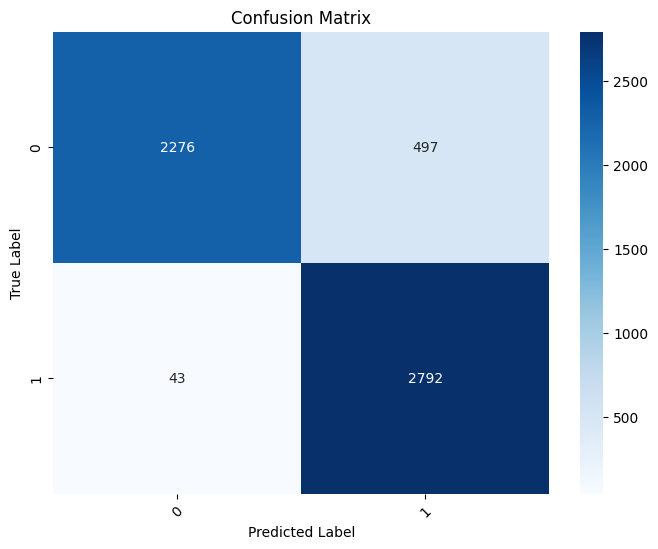

------------------------------------------------------------------------------------------------

Overall Metrics for Test set:
------------------------------------------------------------------------------------------------
Accuracy: 0.9136947218259629
Precision: 0.9218780236773738
Recall (TPR): 0.9136947218259629
False Positive Rate (FPR): 0.08347198434059222
F1 score (F-measure): 0.9135569946785113
Specificity: 0.9165280156594078
------------------------------------------------------------------------------------------------

Classwise Metrics for Test Set:


,Class,Accuracy,Precision,Recall (TPR),FPR,F1 Score (F-measure),TP,FP,TN,FN
0,0,0.913695,0.979592,0.852459,0.019403,0.911614,624,13,657,108
1,1,0.913695,0.858824,0.980597,0.147541,0.915679,657,108,624,13


------------------------------------------------------------------------------------------------
Confusion Matrix for Test Set
------------------------------------------------------------------------------------------------


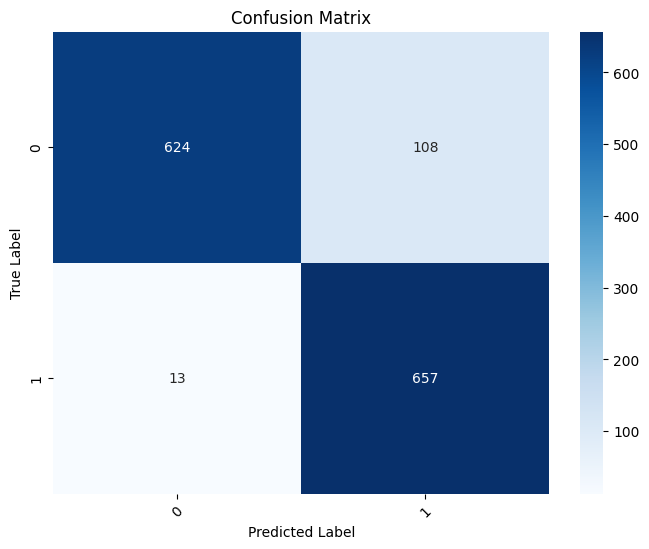

In [ ]:
print("Extra Tree performance for Training and Testing dataset with 10-fold crossvalidation")
print("------------------------------------------------------------------------------------------------")
model = ExtraTreeClassifier()
et_result_1 = runclassifier(model,X_train_shuffled, y_train_shuffled_df, X_test, y_test_df)

AdaBoost

AdaBoost performance for Training and Testing dataset with 10-fold crossvalidation
------------------------------------------------------------------------------------------------
Overall Metrics for Training set:
------------------------------------------------------------------------------------------------
Accuracy: 0.6770684736091298
Precision: 0.677054118189065
Recall (TPR): 0.6770684736091298
False Positive Rate (FPR): 0.3230518396403719
F1 score (F-measure): 0.6770250963563483
Specificity: 0.6769481603596281
------------------------------------------------------------------------------------------------

Classwise Metrics for Training Set:


,Class,Accuracy,Precision,Recall (TPR),FPR,F1 Score (F-measure),TP,FP,TN,FN
0,0,0.677068,0.676061,0.666066,0.312169,0.671026,1847,885,1950,926
1,1,0.677068,0.678025,0.687831,0.333934,0.682893,1950,926,1847,885


------------------------------------------------------------------------------------------------
Confusion Matrix for Train Set
------------------------------------------------------------------------------------------------


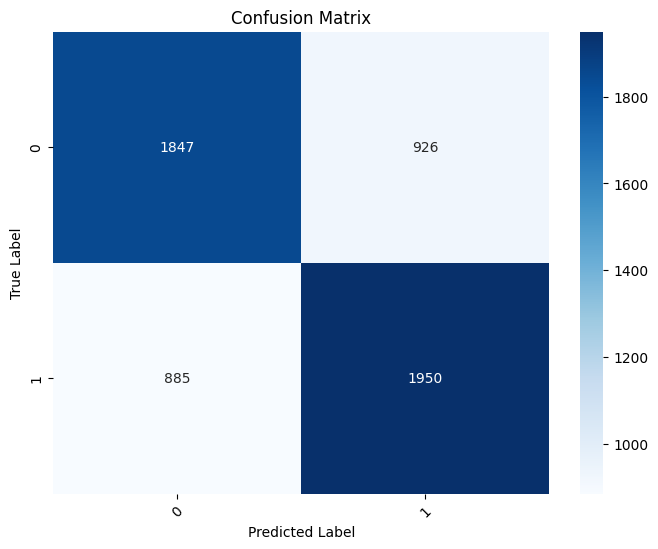

------------------------------------------------------------------------------------------------

Overall Metrics for Test set:
------------------------------------------------------------------------------------------------
Accuracy: 0.6619115549215406
Precision: 0.6621580079390298
Recall (TPR): 0.6619115549215406
False Positive Rate (FPR): 0.3384348748062964
F1 score (F-measure): 0.662001119337171
Specificity: 0.6615651251937036
------------------------------------------------------------------------------------------------

Classwise Metrics for Test Set:


,Class,Accuracy,Precision,Recall (TPR),FPR,F1 Score (F-measure),TP,FP,TN,FN
0,0,0.661912,0.678670,0.669399,0.346269,0.674003,490,232,438,242
1,1,0.661912,0.644118,0.653731,0.330601,0.648889,438,242,490,232


------------------------------------------------------------------------------------------------
Confusion Matrix for Test Set
------------------------------------------------------------------------------------------------


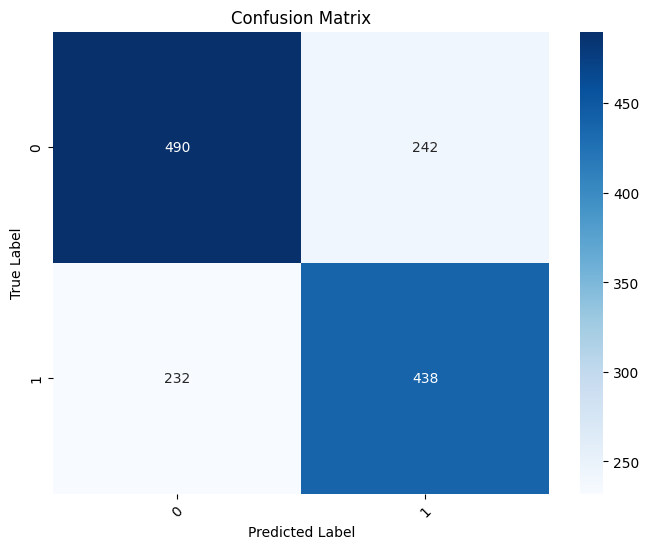

In [ ]:
print("AdaBoost performance for Training and Testing dataset with 10-fold crossvalidation")
print("------------------------------------------------------------------------------------------------")
model = AdaBoostClassifier()
adb_result_1 = runclassifier(model,X_train_shuffled, y_train_shuffled_df, X_test, y_test_df)

XGBoost

XGBoost performance for Training and Testing dataset with 10-fold crossvalidation
------------------------------------------------------------------------------------------------
Overall Metrics for Training set:
------------------------------------------------------------------------------------------------
Accuracy: 0.9165477888730386
Precision: 0.9210284193758094
Recall (TPR): 0.9165477888730386
False Positive Rate (FPR): 0.08403813289015838
F1 score (F-measure): 0.9162724028327682
Specificity: 0.9159618671098416
------------------------------------------------------------------------------------------------

Classwise Metrics for Training Set:


,Class,Accuracy,Precision,Recall (TPR),FPR,F1 Score (F-measure),TP,FP,TN,FN
0,0,0.916548,0.964530,0.862964,0.031041,0.910925,2393,88,2747,380
1,1,0.916548,0.878478,0.968959,0.137036,0.921503,2747,380,2393,88


------------------------------------------------------------------------------------------------
Confusion Matrix for Train Set
------------------------------------------------------------------------------------------------


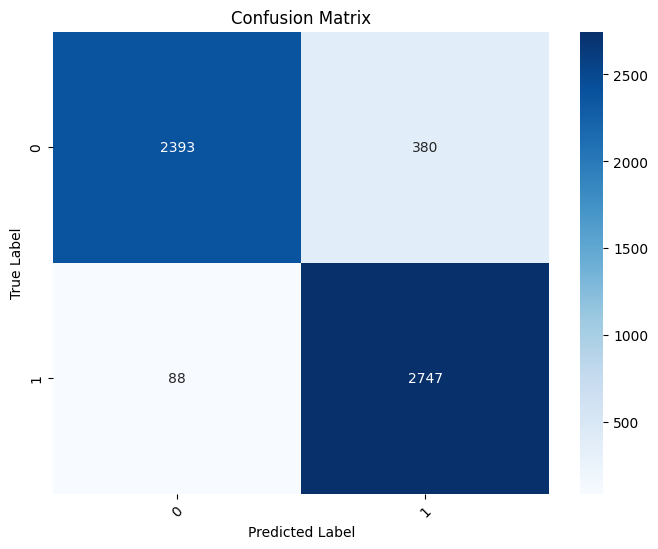

------------------------------------------------------------------------------------------------

Overall Metrics for Test set:
------------------------------------------------------------------------------------------------
Accuracy: 0.9108416547788873
Precision: 0.9162550664739665
Recall (TPR): 0.9108416547788873
False Positive Rate (FPR): 0.08689951879944546
F1 score (F-measure): 0.9107892588345272
Specificity: 0.9131004812005545
------------------------------------------------------------------------------------------------

Classwise Metrics for Test Set:


,Class,Accuracy,Precision,Recall (TPR),FPR,F1 Score (F-measure),TP,FP,TN,FN
0,0,0.910842,0.963359,0.862022,0.035821,0.909877,631,24,646,101
1,1,0.910842,0.864793,0.964179,0.137978,0.911785,646,101,631,24


------------------------------------------------------------------------------------------------
Confusion Matrix for Test Set
------------------------------------------------------------------------------------------------


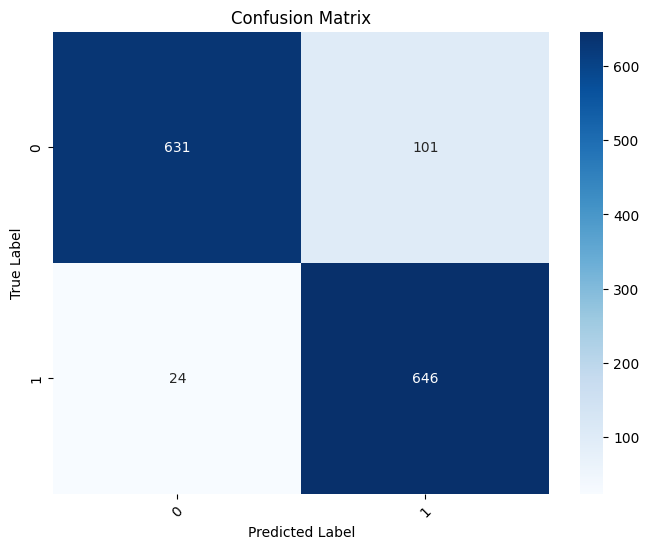

In [ ]:
print("XGBoost performance for Training and Testing dataset with 10-fold crossvalidation")
print("------------------------------------------------------------------------------------------------")
model = XGBClassifier()
xgb_result_1 = runclassifier(model,X_train_shuffled, y_train_shuffled_df, X_test, y_test_df)

GradientBoosting

Gradient Boosting performance for Training and Testing dataset with 10-fold crossvalidation
------------------------------------------------------------------------------------------------
Overall Metrics for Training set:
------------------------------------------------------------------------------------------------
Accuracy: 0.7187945791726106
Precision: 0.7194916587267113
Recall (TPR): 0.7187945791726106
False Positive Rate (FPR): 0.28159272043152317
F1 score (F-measure): 0.7184081405323842
Specificity: 0.7184072795684768
------------------------------------------------------------------------------------------------

Classwise Metrics for Training Set:


,Class,Accuracy,Precision,Recall (TPR),FPR,F1 Score (F-measure),TP,FP,TN,FN
0,0,0.718795,0.730532,0.683375,0.246561,0.706167,1895,699,2136,878
1,1,0.718795,0.708693,0.753439,0.316625,0.730381,2136,878,1895,699


------------------------------------------------------------------------------------------------
Confusion Matrix for Train Set
------------------------------------------------------------------------------------------------


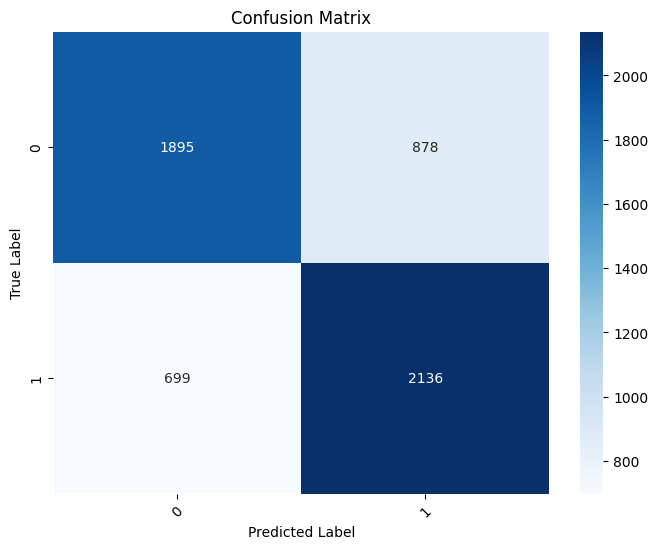

------------------------------------------------------------------------------------------------

Overall Metrics for Test set:
------------------------------------------------------------------------------------------------
Accuracy: 0.7268188302425107
Precision: 0.7277067976249854
Recall (TPR): 0.7268188302425107
False Positive Rate (FPR): 0.2727999347524672
F1 score (F-measure): 0.7269519085745458
Specificity: 0.7272000652475328
------------------------------------------------------------------------------------------------

Classwise Metrics for Test Set:


,Class,Accuracy,Precision,Recall (TPR),FPR,F1 Score (F-measure),TP,FP,TN,FN
0,0,0.726819,0.748222,0.718579,0.264179,0.733101,526,177,493,206
1,1,0.726819,0.705293,0.735821,0.281421,0.720234,493,206,526,177


------------------------------------------------------------------------------------------------
Confusion Matrix for Test Set
------------------------------------------------------------------------------------------------


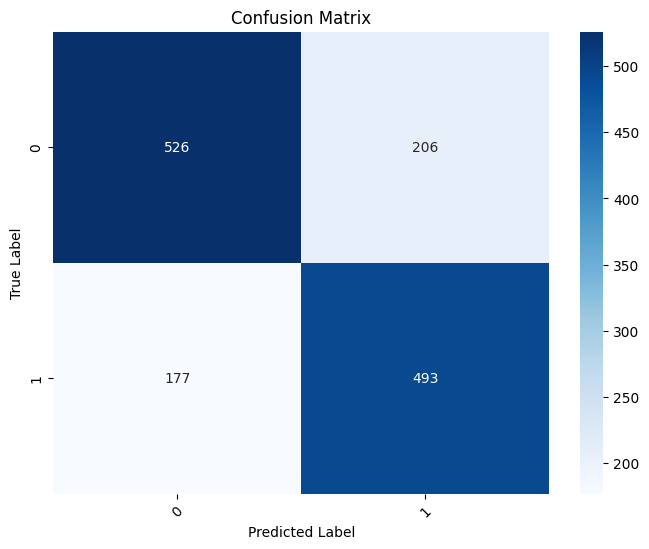

In [ ]:
print("Gradient Boosting performance for Training and Testing dataset with 10-fold crossvalidation")
print("------------------------------------------------------------------------------------------------")
model = GradientBoostingClassifier()
gradboost_result_1 = runclassifier(model,X_train_shuffled, y_train_shuffled_df, X_test, y_test_df)

## DNN

### Feature Extraction Process

Importing Required Libraries

In [31]:
import tensorflow as tf
from tensorflow.keras import layers, models

In [32]:
pip install keras-tuner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 1.5 MB/s eta 0:00:00


In [33]:
import kerastuner
from kerastuner.tuners import GridSearch,RandomSearch
from kerastuner.engine.hyperparameters import HyperParameters
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import SGD, Adam
from typing import Tuple, Union

In [34]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.optimizers import SGD, Adam, RMSprop

In [35]:
# Creating copies of our dataframes
X_train_dnn = X_train_shuffled.copy()
X_test_dnn = X_test.copy()
y_train_dnn = y_train_shuffled_df.copy()
y_test_dnn = y_test_df.copy()

In [36]:
# converting categorical labels into a one-hot encoded format
y_train_keras_dnn = keras.utils.to_categorical(y_train_dnn, 2)
y_test_keras_dnn = keras.utils.to_categorical(y_test_dnn, 2)

In [37]:
# creating a validation set
X_train_cv_dnn, X_val_cv_dnn, y_train_cv_dnn, y_val_cv_dnn = train_test_split(X_train_dnn, y_train_keras_dnn, test_size=0.2, random_state=42)

Building the neural network

In [38]:
import random

# Set a fixed random seed
np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)

def MLP_builder_Tuning(hp: HyperParameters):
    hidden_layers = hp.Int('hidden_layers', min_value=1, max_value=5)
    activation_function = hp.Choice('activation_function', values=['relu', 'sigmoid', 'tanh'])
    learning_rate = hp.Float('learning_rate', min_value=1e-4, max_value=1e-1, sampling='log')
    momentum_rate = hp.Float('momentum_rate', min_value=0.0, max_value=0.9)
    optimizer = hp.Choice('optimizer', values=['SGD', 'Adam', 'RMSprop'])
    # Use a custom initializer with a fixed seed
    initializer = tf.initializers.GlorotUniform(seed=42)

    model = Sequential()
    for _ in range(hidden_layers):
        model.add(Dense(units=hp.Int('units', min_value=32, max_value=512, step=32),
                        activation=activation_function,
                        kernel_initializer=initializer,  # Set the custom initializer
                        input_dim=X_train_dnn.shape[1]))
    model.add(Dense(2, activation='sigmoid'))
    if optimizer == 'SGD':
        model.compile(loss='binary_crossentropy', optimizer=SGD(learning_rate=learning_rate, momentum=momentum_rate), metrics=['accuracy'])
    elif optimizer == 'Adam':
        model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=learning_rate), metrics=['accuracy'])
    elif optimizer == 'RMSprop':
        model.compile(loss='binary_crossentropy', optimizer=RMSprop(learning_rate=learning_rate), metrics=['accuracy'])
    return model

# Create a GridSearch tuner
tuner = GridSearch(MLP_builder_Tuning, objective='val_accuracy', max_trials=20,  # Number of hyperparameter combinations to try
    directory='/content/drive/MyDrive/Kaggle',  # Directory to save the tuning results
    project_name='heart_disease_dnn_grid_01',
    seed=42
)

# Perform the hyperparameter search
tuner.search(x=X_train_cv_dnn, y=y_train_cv_dnn, epochs=50, validation_data=(X_val_cv_dnn, y_val_cv_dnn))
# Get the best hyperparameters
best_hps = tuner.oracle.get_best_trials(num_trials=1)[0].hyperparameters
print("Best Hyperparameters:", best_hps.get_config()['values'])


Reloading Tuner from /content/drive/MyDrive/Kaggle/heart_disease_dnn_grid_01/tuner0.json
Best Hyperparameters: {'hidden_layers': 1, 'activation_function': 'relu', 'learning_rate': 0.0001, 'momentum_rate': 0.0, 'optimizer': 'Adam', 'units': 128}


In [ ]:
# the hyperparameter combinations tested, and the results for each trial:
tuner.results_summary()

Results summary
Results in /content/drive/MyDrive/Kaggle/heart_disease_dnn_grid_01
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 19 summary
Hyperparameters:
hidden_layers: 1
activation_function: relu
learning_rate: 0.0001
momentum_rate: 0.0
optimizer: Adam
units: 128
Score: 0.6729055047035217

Trial 17 summary
Hyperparameters:
hidden_layers: 1
activation_function: relu
learning_rate: 0.0001
momentum_rate: 0.0
optimizer: Adam
units: 64
Score: 0.6550801992416382

Trial 18 summary
Hyperparameters:
hidden_layers: 1
activation_function: relu
learning_rate: 0.0001
momentum_rate: 0.0
optimizer: Adam
units: 96
Score: 0.6550801992416382

Trial 05 summary
Hyperparameters:
hidden_layers: 1
activation_function: relu
learning_rate: 0.0001
momentum_rate: 0.0
optimizer: SGD
units: 192
Score: 0.6524063944816589

Trial 07 summary
Hyperparameters:
hidden_layers: 1
activation_function: relu
learning_rate: 0.0001
momentum_rate: 0.0
optimizer: SGD
units: 256
Score: 0.6497326

Extracting the Features

In [39]:
model_nn = MLP_builder_Tuning(best_hps)

In [40]:
model_nn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               2048      
                                                                 
 dense_1 (Dense)             (None, 2)                 258       
                                                                 
Total params: 2306 (9.01 KB)
Trainable params: 2306 (9.01 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [41]:
from keras.models import Model
intermediate_layer_model = Model(inputs=model_nn.input, outputs=model_nn.layers[-2].output)
model_nn.trainable = False # freezes the weights of the pre-trained model, ensuring that they are not modified during feature extraction.

# Predict the features for the combined dataset X
X_combined_dnn = np.concatenate([X_train_dnn, X_test_dnn])
X_extracted_dnn = intermediate_layer_model.predict(X_combined_dnn)

220/220 [==============================] - 1s 2ms/step


In [42]:
X_extracted_dnn_df= pd.DataFrame(X_extracted_dnn)

In [43]:
X_extracted_dnn_df

,0,1,2,3,4,5,6,7,8,9,...,118,119,120,121,122,123,124,125,126,127
0,0.0,0.0,27.494219,32.569126,0.0,0.0,0.0,12.272173,9.151602,7.691097,...,0.0,0.0,29.776423,0.0,16.473742,12.041467,2.352890,0.0,0.964229,20.279383
1,0.0,0.0,30.233658,33.934654,0.0,0.0,0.0,6.791475,14.868569,15.324582,...,0.0,0.0,43.959679,0.0,22.859167,0.000000,7.452736,0.0,12.272823,32.649475
2,0.0,0.0,32.807587,44.166233,0.0,0.0,0.0,9.728728,16.224150,17.760834,...,0.0,0.0,45.472527,0.0,18.070105,4.939571,0.000000,0.0,11.888162,32.497665
3,0.0,0.0,30.083529,42.486965,0.0,0.0,0.0,13.438134,12.345666,17.586416,...,0.0,0.0,50.161457,0.0,20.433550,0.000000,6.890163,0.0,11.624759,34.437794
4,0.0,0.0,35.458614,37.271873,0.0,0.0,0.0,9.682649,18.781836,10.518439,...,0.0,0.0,41.954929,0.0,23.450930,5.938998,5.773839,0.0,6.258379,32.067959
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7005,0.0,0.0,35.885765,38.818493,0.0,0.0,0.0,9.660538,15.717584,13.602660,...,0.0,0.0,48.982422,0.0,16.140572,0.000000,0.000000,0.0,10.882883,40.446106
7006,0.0,0.0,25.827869,32.256401,0.0,0.0,0.0,12.849762,7.275067,7.825513,...,0.0,0.0,32.435783,0.0,16.169094,7.983926,8.027325,0.0,1.731654,22.091953
7007,0.0,0.0,35.362335,42.256031,0.0,0.0,0.0,13.983216,12.725151,16.299080,...,0.0,0.0,51.816597,0.0,14.563407,0.000000,0.000000,0.0,10.027163,40.124046
7008,0.0,0.0,26.369652,36.468742,0.0,0.0,0.0,10.955465,8.555500,14.772053,...,0.0,0.0,38.406597,0.0,20.445486,7.177613,8.926558,0.0,6.695204,22.583031


A total of 128 features were extracted

In [44]:
# Check for outliers in the scaled data
outliers_extracted_dnn = detect_outliers_iqr(X_extracted_dnn)
#outliers_extracted_dnn

Number of Outliers: 55868.85


Text(0.5, 0, 'Square Root-Transformed Values')

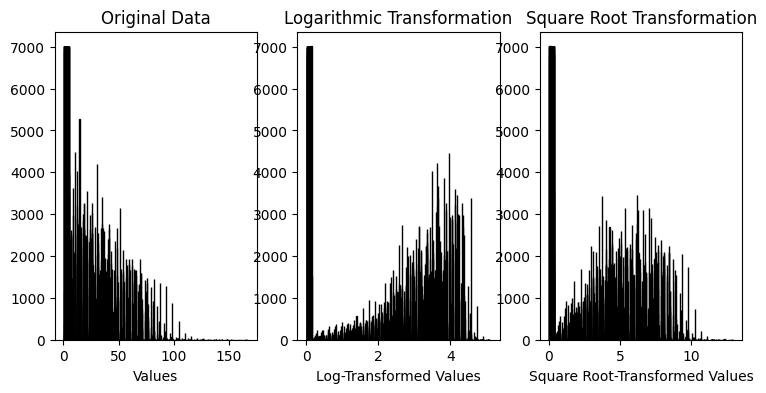

In [45]:
# Plot the original data
plt.figure(figsize=(12, 4))

plt.subplot(1, 4, 1)
plt.title('Original Data')
plt.hist(X_extracted_dnn, bins=30, edgecolor='black')
plt.xlabel('Values')

# Logarithmic Transformation
log_transformed_data = np.log1p(X_extracted_dnn)

plt.subplot(1, 4, 2)
plt.title('Logarithmic Transformation')
plt.hist(log_transformed_data, bins=30, edgecolor='black')
plt.xlabel('Log-Transformed Values')

# Square Root Transformation
sqrt_transformed_data = np.sqrt(X_extracted_dnn)

plt.subplot(1, 4, 3)
plt.title('Square Root Transformation')
plt.hist(sqrt_transformed_data, bins=30, edgecolor='black')
plt.xlabel('Square Root-Transformed Values')


In [46]:
print("After log root transformation", detect_outliers_iqr(log_transformed_data))
print("After square root transformation", detect_outliers_iqr(sqrt_transformed_data))

Number of Outliers: 0.0
After log root transformation []
Number of Outliers: 0.0
After square root transformation []


In [47]:
log_transformed_data_df = pd.DataFrame(log_transformed_data)
sqrt_transformed_data_df = pd.DataFrame(sqrt_transformed_data)

Comparing between log transformation and square root transformation, we see square root transformation has resulted in a normally data distribution compared to the log transformation.

In [ ]:
sqrt_transformed_data

array([[0.        , 0.8688112 , 0.944395  , ..., 0.        , 0.28257746,
        0.8986772 ],
       [0.        , 0.73670655, 0.3961258 , ..., 0.52896065, 0.        ,
        0.        ],
       [0.4810638 , 0.63558125, 0.75084955, ..., 0.        , 0.        ,
        0.74263114],
       ...,
       [0.6438045 , 0.74324477, 0.8975489 , ..., 0.        , 0.        ,
        0.8819491 ],
       [0.4580094 , 0.3578239 , 0.5734014 , ..., 0.        , 0.        ,
        0.48030975],
       [0.        , 0.36345965, 0.5027239 , ..., 0.20845808, 0.17438895,
        0.40307373]], dtype=float32)

### Feature Selection

Importing required libraries

In [48]:
!pip install deap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.4/135.4 kB 1.2 MB/s eta 0:00:00


In [49]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import random
import copy
from itertools import repeat
import shutil
import time
import math
import array

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools import add_constant

from sklearn.base import BaseEstimator
from sklearn.metrics import r2_score, mean_absolute_error

from joblib import Parallel, delayed, dump, load
from joblib.externals.loky import get_reusable_executor

from deap import algorithms
from deap import base
from deap import creator
from deap import tools
from tqdm.notebook import tqdm

plt.style.use('seaborn-v0_8-whitegrid')

In [50]:
Y_dnn = np.concatenate([y_train_dnn,y_test_dnn])

In [51]:
y_dnn_df = pd.DataFrame(Y_dnn)

Code reference : https://github.com/FlorinAndrei/fast_feature_selection/blob/main/feature_selection.ipynb

In [52]:
# Define the fitness weights and other parameters
fitness_weights = -1.0
population_size = 100
n_gen = 100
n_jobs = os.cpu_count()

# Define the dataframes X_ga and y_ga
X_ga = sqrt_transformed_data_df.astype(float).copy()
y_ga = y_dnn_df.astype(float).copy()
X_features = X_ga.columns.to_list()[1:]


def evalMany(individuals):
    # - each individual is a list of feature selectors
    ind_list = [list(i) for i in list(individuals)]
    ret = []
    for ind in ind_list:
        cols_select = [i == 1 for i in list(ind)] + [False] # create a list of True/False feature selectors from each individual
        # fit model using the features selected from the individual
        lin_mod = sm.OLS(y_ga, X_ga.loc[:, cols_select], hasconst=True).fit()
        ret.append((lin_mod.bic,))
    return ret

# Define the custom selection function
def selElitistAndTournament(individuals, k_tournament, k_elitist=0, tournsize=3):
    return tools.selBest(individuals, k_elitist) + tools.selTournament(individuals, k_tournament, tournsize)

# multiprocess pool to evaluate individuals
def joblib_map(f, njobs, *iters):
    return Parallel(n_jobs=njobs)(delayed(f)(*args) for args in zip(*iters))

try:
    del creator.FitnessMax
    del creator.Individual
except Exception as e:
    pass

creator.create("FitnessMax", base.Fitness, weights=(fitness_weights,))
creator.create("Individual", array.array, typecode='b', fitness=creator.FitnessMax)

# Hyperparameters
population_size = 100
crossover_probability = 0.5
individual_mutation_probability = 0.2
gene_mutation_probability = 0.1
tournament_size = 3
elite_size = 0

try:
    del toolbox
except Exception as e:
    pass

toolbox = base.Toolbox()
toolbox.register("attr_bool", random.randint, 0, 1)
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_bool, len(X_features))
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("map_multi", joblib_map)
toolbox.register("evaluate", evalMany)
toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutFlipBit, indpb=gene_mutation_probability)
toolbox.register("select",selElitistAndTournament,k_tournament=population_size - elite_size,k_elitist=elite_size,tournsize=tournament_size,)

random.seed(42)
population = toolbox.population(n=population_size)
hall_of_fame = tools.HallOfFame(1)
objective_runs_ga = 0

# Evaluate the individuals with an invalid fitness
invalid_ind = [ind for ind in population if not ind.fitness.valid]
# split the population in a list with n_jobs elements where each element is an array containing multiple individuals
fitnesses_nested = toolbox.map_multi(
    toolbox.evaluate, n_jobs, np.array_split(invalid_ind, n_jobs) # send individuals to the evaluator
)
objective_runs_ga += len(invalid_ind)
fitnesses = []
for l in fitnesses_nested:
    fitnesses += l
for ind, fit in zip(invalid_ind, fitnesses):
    ind.fitness.values = fit

hall_of_fame.update(population)

n_gen = 100
best_objective_per_gen_ga = np.full(n_gen, np.nan)
best_objective_ga = np.nan
best_generation_ga = 0
gene_values_mean = np.zeros((n_gen, len(X_features)))
gene_maes = np.full(n_gen, np.nan)
time_to_best_ga = np.inf
# Begin the generational process
iterator = tqdm(range(1, n_gen + 1), desc='generation')
t_start = time.time()

for gen in iterator:
    t_start_loop = time.time()

    # Select the next generation of individuals
    offspring = toolbox.select(population)
    # Vary the pool of individuals via cross-over and mutation
    offspring = algorithms.varAnd(
        offspring,
        toolbox,
        crossover_probability,
        individual_mutation_probability,
    )
    # Evaluate the individuals with an invalid fitness
    invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
    # split the population in a list with n_jobs elements
    # each element is an array containing multiple individuals
    # send list to the evaluator pool
    fitnesses_nested = toolbox.map_multi(
        toolbox.evaluate, n_jobs, np.array_split(invalid_ind, n_jobs)
    )
    objective_runs_ga += len(invalid_ind)
    fitnesses = []
    for l in fitnesses_nested:
        fitnesses += l
    for ind, fit in zip(invalid_ind, fitnesses):
        ind.fitness.values = fit
    # Update the hall of fame with the generated individuals
    hall_of_fame.update(offspring)
    # Replace the current population by the offspring
    population[:] = offspring

    t_end_loop = time.time()
    # record the mean gene values across the population
    gene_values_mean[gen - 1, :] = np.array(population).mean(axis=0)
    if gen >= 2:
        gene_maes[gen - 1] = mean_absolute_error(
            gene_values_mean[gen - 2, :], gene_values_mean[gen - 1, :]
        )
    # pick best individual for stats recording
    best_individual_ga = tools.selBest(population, 1)[0]
    best_objective_per_gen_ga[gen - 1] = best_individual_ga.fitness.values[0]
    if (
        best_objective_ga is np.nan
        or fitness_weights * best_individual_ga.fitness.values[0]
        > fitness_weights * best_objective_ga
    ):
        best_objective_ga = best_individual_ga.fitness.values[0]
        best_generation_ga = gen
        time_to_best_ga = t_end_loop - t_start
        print(
            f'gen: {gen:4n}, curr/prev gene MAE: {gene_maes[gen - 1]:.4f}, new best objective: {best_objective_ga:.4f}, time to best: {time_to_best_ga:.4f}'
        )

    if os.path.isfile('break'):
        # to gracefully break the loop, manually create a file called 'break'
        print(f'Found break file, stopping now.')
        iterator.close()
        break
g_completed_ga = gen

best_individual_ga = list(hall_of_fame[0])
best_features_ga = [
    X_features[i] for i, val in enumerate(best_individual_ga) if val == 1
]
best_objective_ga = (
    sm.OLS(y_ga, X_ga[best_features_ga], hasconst=True).fit().bic
)

generation:   0%|          | 0/100 [00:00<?, ?it/s]

gen:    1, curr/prev gene MAE: nan, new best objective: 9327.0174, time to best: 5.1114
gen:    3, curr/prev gene MAE: 0.0814, new best objective: 9306.7701, time to best: 14.0783
gen:    4, curr/prev gene MAE: 0.0649, new best objective: 9280.7210, time to best: 17.9037
gen:    7, curr/prev gene MAE: 0.0754, new best objective: 9277.9992, time to best: 28.8070
gen:    8, curr/prev gene MAE: 0.0498, new best objective: 9275.7366, time to best: 31.8809
gen:    9, curr/prev gene MAE: 0.0318, new best objective: 9249.2135, time to best: 34.8459
gen:   11, curr/prev gene MAE: 0.0525, new best objective: 9244.7633, time to best: 41.5676
gen:   12, curr/prev gene MAE: 0.0434, new best objective: 9218.9922, time to best: 44.3522
gen:   15, curr/prev gene MAE: 0.0283, new best objective: 9209.4728, time to best: 52.1982
gen:   16, curr/prev gene MAE: 0.0338, new best objective: 9202.7362, time to best: 55.8713
gen:   18, curr/prev gene MAE: 0.0277, new best objective: 9197.8384, time to best: 

Best objective:  9439.16794633612
Best generation: 99
Objective runs:  6130
Time to best:    185.271 sec
Best features:   [2, 6, 9, 10, 15, 23, 24, 27, 28, 31, 32, 36, 37, 39, 40, 41, 44, 45, 50, 55, 61, 63, 67, 69, 70, 73, 74, 79, 85, 87, 88, 89, 90, 91, 92, 94, 96, 102, 106, 113, 115, 118, 119, 120, 126, 127]


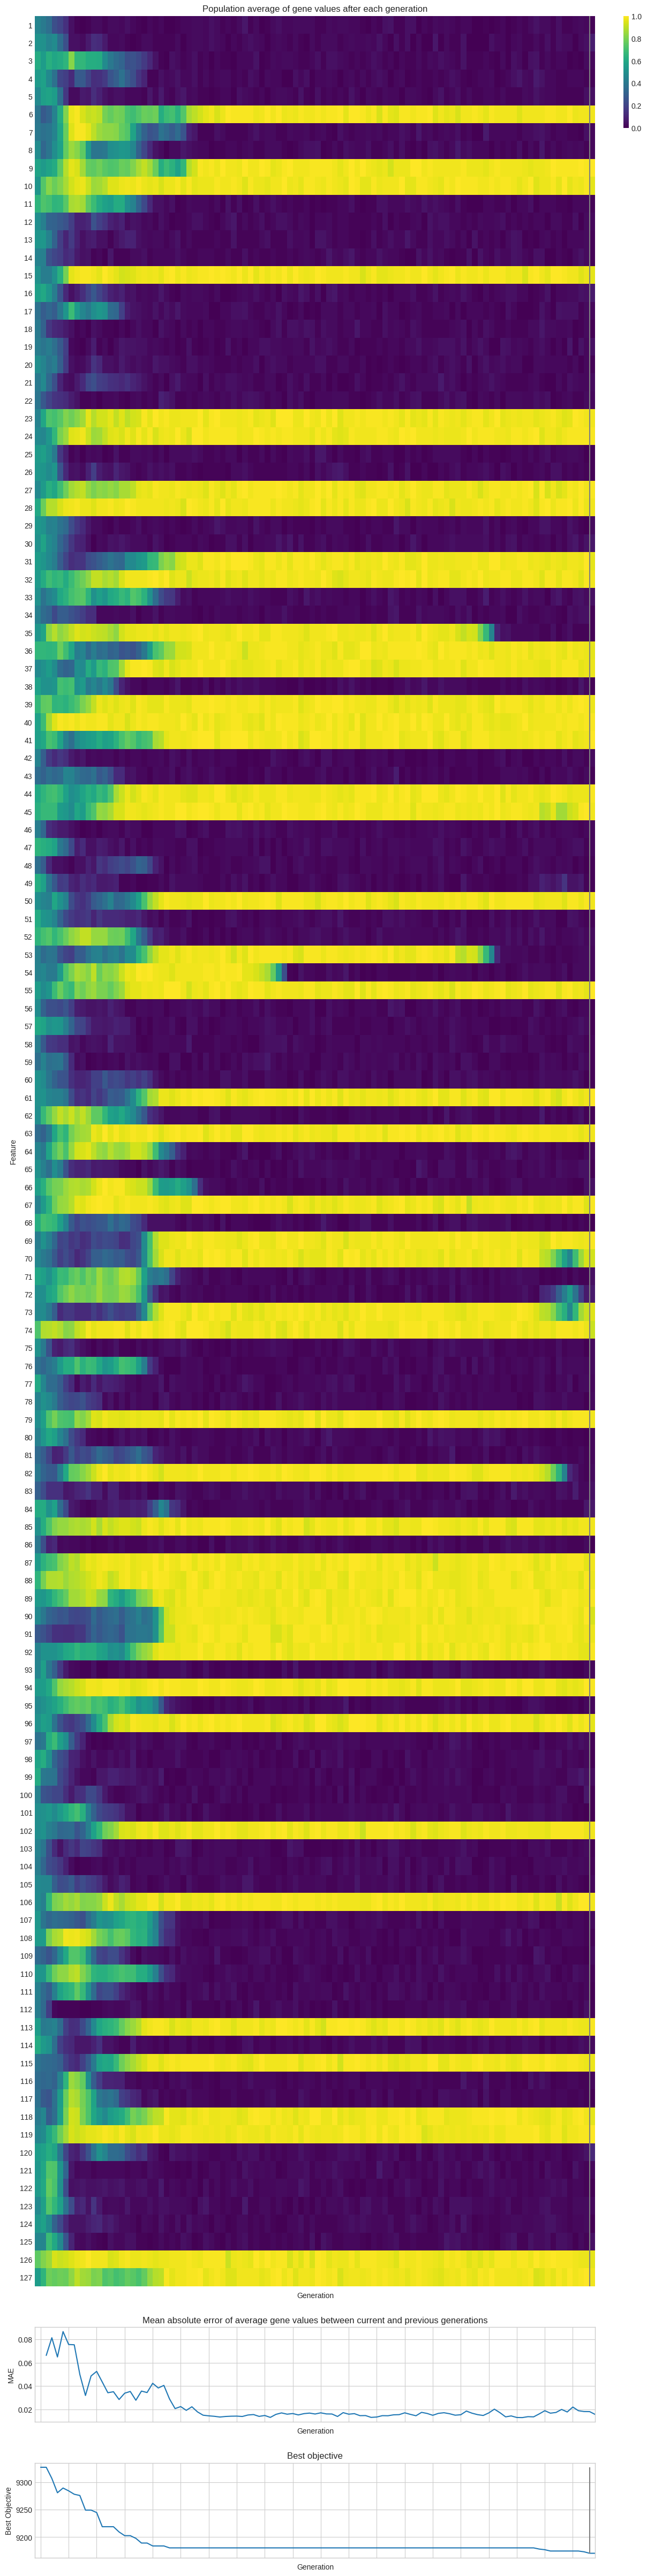

In [57]:
# Print best objective, best generation, objective runs, and time to best
print(f'Best objective:  {best_objective_ga}')
print(f'Best generation: {best_generation_ga}')
print(f'Objective runs:  {objective_runs_ga}')
print(f'Time to best:    {time_to_best_ga:.3f} sec')

# Print best features
print(f'Best features:   {best_features_ga}')

# Create a DataFrame for the population average of gene values
gvm_df = pd.DataFrame(
    gene_values_mean[:g_completed_ga],
    columns=X_features,
    index=range(1, g_completed_ga + 1)
)

# Plotting
fig, ax = plt.subplots(
    3,
    1,
    sharex=True,
    height_ratios=[24, 1, 1],
    figsize=(12, 48),
    layout='constrained',
)
sns.heatmap(
    gvm_df.T,
    vmin=0.0,
    vmax=1.0,
    cmap='viridis',
    cbar=True,
    cbar_kws={'fraction': 0.01, 'anchor': (0.0, 1.0)},
    ax=ax[0]
)
ax[0].set_title('Population average of gene values after each generation')
ax[0].axvline(x=best_generation_ga, color='C7')
ax[0].set_xlabel('Generation')
ax[0].set_ylabel('Feature')
ax[0].set_xticks(range(1, g_completed_ga + 1, max(g_completed_ga // 20, 1)))
ax[0].tick_params(axis='both', reset=True)

ax[1].plot(range(2, g_completed_ga + 1), gene_maes[1:g_completed_ga])
ax[1].vlines(x=best_generation_ga, ymin=min(gene_maes), ymax=max(gene_maes), colors='C7')
ax[1].set_xlabel('Generation')
ax[1].set_ylabel('MAE')
ax[1].set_title('Mean absolute error of average gene values between current and previous generations')
ax[1].tick_params(axis='both', reset=True)

ax[2].plot(range(1, g_completed_ga + 1), best_objective_per_gen_ga[:g_completed_ga])
ax[2].vlines(x=best_generation_ga, ymin=min(best_objective_per_gen_ga), ymax=max(best_objective_per_gen_ga), colors='C7')
ax[2].set_xlabel('Generation')
ax[2].set_ylabel('Best Objective')
ax[2].set_title('Best objective')
ax[2].tick_params(axis='both', reset=True)

# Adjust layout and save/show the figure
#fig.tight_layout()
#fig.subplots_adjust(top=0.95)
fig.savefig('ga-performance.png')
plt.show()


In [ ]:
import pickle

# Save all the relevant values to a dictionary
results = {
    'best_objective': best_objective_ga,
    'best_generation': best_generation_ga,
    'objective_runs': objective_runs_ga,
    'time_to_best': time_to_best_ga,
    'best_features': best_features_ga,
    'gene_values_mean': gene_values_mean,
    'gene_maes': gene_maes,
    'best_objective_per_gen': best_objective_per_gen_ga
}

# Save the dictionary to a file
with open('dnn_ga_results.pkl', 'wb') as f:
    pickle.dump(results, f)

In [58]:
import pickle

# Load the dictionary from the file
with open('/content/drive/MyDrive/Kaggle/dnn_ga_results.pkl', 'rb') as f:
    results_loaded = pickle.load(f)

# Access the individual values as needed
best_objective_loaded_dnn = results_loaded['best_objective']
best_generation_loaded_dnn = results_loaded['best_generation']
objective_runs_loaded_dnn = results_loaded['objective_runs']
time_to_best_loaded_dnn = results_loaded['time_to_best']
best_features_loaded_dnn = results_loaded['best_features']
gene_values_mean_loaded_dnn = results_loaded['gene_values_mean']
gene_maes_loaded_dnn = results_loaded['gene_maes']
best_objective_per_gen_loaded_dnn = results_loaded['best_objective_per_gen']


In [59]:
# copy the original dataframes into local copies, once
X_ga_dnn = sqrt_transformed_data_df.astype(float).copy()
y_ga_dnn = y_dnn_df.astype(float).copy()

In [60]:
selected_features_dnn_df = X_ga_dnn[best_features_loaded_dnn]
X_train_selected_dnn_ga, X_test_selected_dnn_ga, y_train_dnn_ga, y_test_dnn_ga = train_test_split(selected_features_dnn_df, y_dnn_df, test_size=0.2, random_state=42)

In [61]:
y_test_dnn_ga.columns = ['TenYearCHD']
y_train_dnn_ga.columns = ['TenYearCHD']

In [62]:
X_train_selected_dnn_ga.shape

(5608, 41)

### Model Evaluation and ParameterTuning

Importing required libraries

In [63]:
!pip3 install optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 21.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.8/78.8 kB 8.7 MB/s eta 0:00:00


In [64]:
import optuna
from optuna.samplers import TPESampler
import pickle

Gaussian Naive Bayes

In [ ]:
def objective_gnb(trial):
    var_smoothing = trial.suggest_float("var_smoothing", 1e-10, 1e-5, log=True)
    model = GaussianNB(var_smoothing=var_smoothing)
    model.fit(X_train_selected_dnn_ga, y_train_dnn_ga)
    y_pred = model.predict(X_test_selected_dnn_ga)
    return accuracy_score(y_test_dnn_ga, y_pred)

In [ ]:
sampler = TPESampler(seed=1)
study_gnb = optuna.create_study(direction="maximize", sampler=sampler)
study_gnb.optimize(objective_gnb, n_trials=100)

print("Number of finished trials: ", len(study_gnb.trials))
print("Best trial:")
trial = study_gnb.best_trial
print("  Value: ", trial.value)
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2024-04-14 21:26:32,417] A new study created in memory with name: no-name-9de13e8c-79a1-44fe-bbe4-b4ecc36e24b3
[I 2024-04-14 21:26:32,455] Trial 0 finished with value: 0.5763195435092725 and parameters: {'var_smoothing': 1.2164941464151851e-08}. Best is trial 0 with value: 0.5763195435092725.
[I 2024-04-14 21:26:32,485] Trial 1 finished with value: 0.579172610556348 and parameters: {'var_smoothing': 3.995972283135059e-07}. Best is trial 1 with value: 0.579172610556348.
[I 2024-04-14 21:26:32,515] Trial 2 finished with value: 0.5691868758915835 and parameters: {'var_smoothing': 1.0013176560941255e-10}. Best is trial 1 with value: 0.579172610556348.
[I 2024-04-14 21:26:32,569] Trial 3 finished with value: 0.5741797432239658 and parameters: {'var_smoothing': 3.2483503450866807e-09}. Best is trial 1 with value: 0.579172610556348.
[I 2024-04-14 21:26:32,635] Trial 4 finished with value: 0.5763195435092725 and parameters: {'var_smoothing': 5.417257182767975e-10}. Best is trial 1 with valu

Number of finished trials:  100
Best trial:
  Value:  0.5898716119828816
  Params: 
    var_smoothing: 9.966285964539326e-06


Hypertuned Gaussian Naive Bayes performance for Selected Training and Testing dataset with 10-fold crossvalidation
------------------------------------------------------------------------------------------------
Overall Metrics for Training set:
------------------------------------------------------------------------------------------------
Accuracy: 0.5590228245363766
Precision: 0.6288477950993858
Recall (TPR): 0.5590228245363766
False Positive Rate (FPR): 0.43929267294705954
F1 score (F-measure): 0.4922063835458268
Specificity: 0.5607073270529405
------------------------------------------------------------------------------------------------

Classwise Metrics for Training Set:


,Class,Accuracy,Precision,Recall (TPR),FPR,F1 Score (F-measure),TP,FP,TN,FN
0,0,0.559023,0.532851,0.924042,0.802627,0.675927,2579,2261,556,212
1,1,0.559023,0.723958,0.197373,0.075958,0.310181,556,212,2579,2261


------------------------------------------------------------------------------------------------
Confusion Matrix for Train Set
------------------------------------------------------------------------------------------------


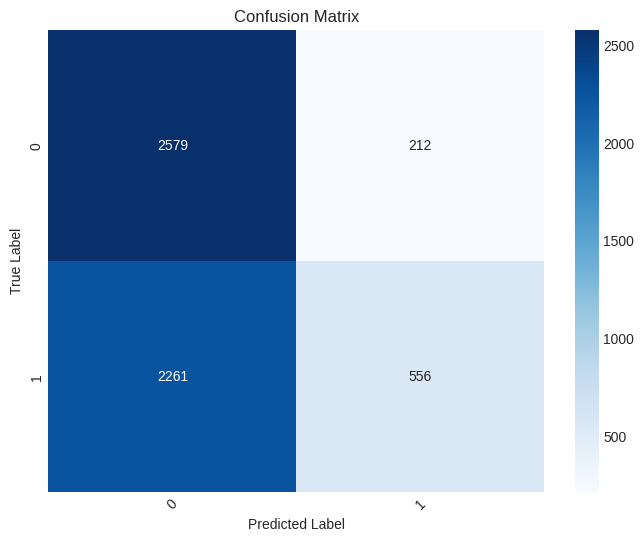

------------------------------------------------------------------------------------------------

Overall Metrics for Test set:
------------------------------------------------------------------------------------------------
Accuracy: 0.5898716119828816
Precision: 0.6743903018687921
Recall (TPR): 0.5898716119828816
False Positive Rate (FPR): 0.41684580809067817
F1 score (F-measure): 0.5268690370227423
Specificity: 0.5831541919093218
------------------------------------------------------------------------------------------------

Classwise Metrics for Test Set:


,Class,Accuracy,Precision,Recall (TPR),FPR,F1 Score (F-measure),TP,FP,TN,FN
0,0,0.589872,0.557391,0.945378,0.779070,0.701299,675,536,152,39
1,1,0.589872,0.795812,0.220930,0.054622,0.345848,152,39,675,536


------------------------------------------------------------------------------------------------
Confusion Matrix for Test Set
------------------------------------------------------------------------------------------------


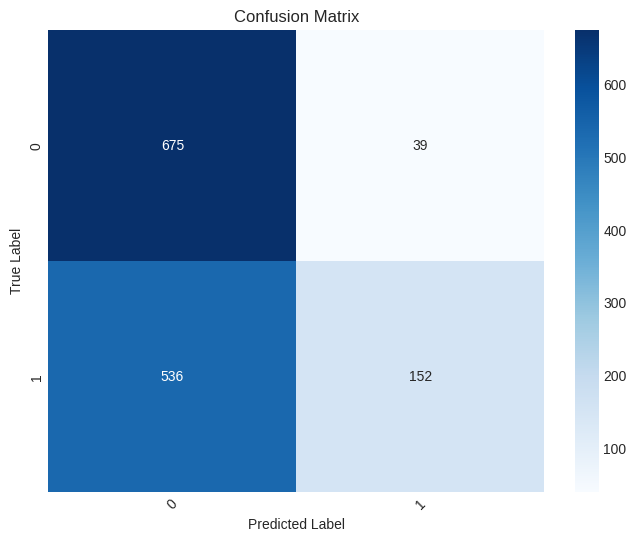

In [ ]:
print("Hypertuned Gaussian Naive Bayes performance for Selected Training and Testing dataset with 10-fold crossvalidation")
print("------------------------------------------------------------------------------------------------")
model_gb = GaussianNB(var_smoothing = trial.params['var_smoothing'])
gb_result_2 = runclassifier(model_gb,X_train_selected_dnn_ga, y_train_dnn_ga,X_test_selected_dnn_ga, y_test_dnn_ga)

Gaussian Naive Bayes performance for Selected Training and Testing dataset with 10-fold crossvalidation
------------------------------------------------------------------------------------------------
Overall Metrics for Training set:
------------------------------------------------------------------------------------------------
Accuracy: 0.5481455064194009
Precision: 0.6489978068687454
Recall (TPR): 0.5481455064194009
False Positive Rate (FPR): 0.4499660211641786
F1 score (F-measure): 0.4585896404511548
Specificity: 0.5500339788358214
------------------------------------------------------------------------------------------------

Classwise Metrics for Training Set:


,Class,Accuracy,Precision,Recall (TPR),FPR,F1 Score (F-measure),TP,FP,TN,FN
0,0,0.548146,0.525260,0.957363,0.857295,0.678345,2672,2415,402,119
1,1,0.548146,0.771593,0.142705,0.042637,0.240863,402,119,2672,2415


------------------------------------------------------------------------------------------------
Confusion Matrix for Train Set
------------------------------------------------------------------------------------------------


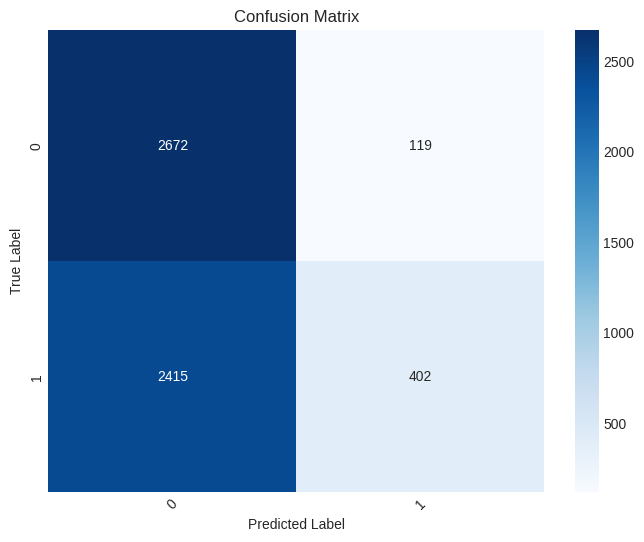

------------------------------------------------------------------------------------------------

Overall Metrics for Test set:
------------------------------------------------------------------------------------------------
Accuracy: 0.5748930099857347
Precision: 0.685048139450838
Recall (TPR): 0.5748930099857347
False Positive Rate (FPR): 0.4325043971076803
F1 score (F-measure): 0.4931645303539655
Specificity: 0.5674956028923197
------------------------------------------------------------------------------------------------

Classwise Metrics for Test Set:


,Class,Accuracy,Precision,Recall (TPR),FPR,F1 Score (F-measure),TP,FP,TN,FN
0,0,0.574893,0.546751,0.966387,0.831395,0.698381,690,572,116,24
1,1,0.574893,0.828571,0.168605,0.033613,0.280193,116,24,690,572


------------------------------------------------------------------------------------------------
Confusion Matrix for Test Set
------------------------------------------------------------------------------------------------


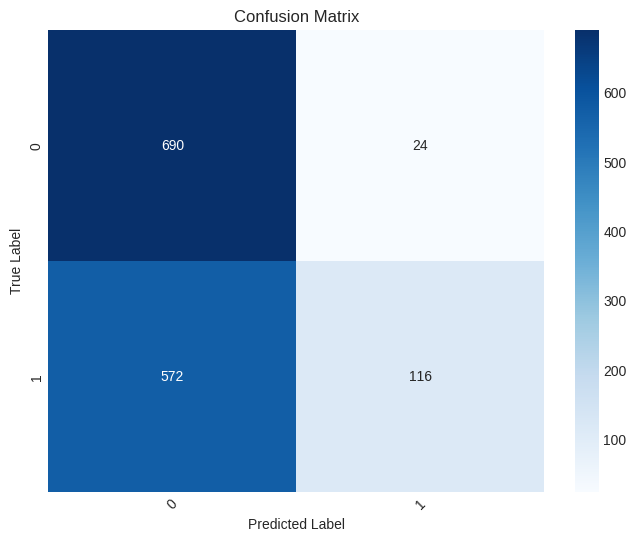

In [ ]:
print("Gaussian Naive Bayes performance for Selected Training and Testing dataset with 10-fold crossvalidation")
print("------------------------------------------------------------------------------------------------")
model = GaussianNB()
gb_result_3 = runclassifier(model,X_train_selected_dnn_ga, y_train_dnn_ga,X_test_selected_dnn_ga, y_test_dnn_ga)

Logistic Regression

In [ ]:
def objective_lr(trial):
    penalty  = trial.suggest_categorical("penalty", ['l2'])
    solvers  = trial.suggest_categorical('solvers', ['newton-cg', 'lbfgs', 'liblinear'])
    C = trial.suggest_categorical("C", [100, 10, 1.0, 0.1, 0.01])
    model = LogisticRegression(solver=solvers,penalty=penalty,C=C)
    model.fit(X_train_selected_dnn_ga, y_train_dnn_ga)
    y_pred = model.predict(X_test_selected_dnn_ga)
    return accuracy_score(y_test_dnn_ga, y_pred)

In [ ]:
sampler = TPESampler(seed=1)
study_lr = optuna.create_study(direction="maximize", sampler=sampler)
study_lr.optimize(objective_lr, n_trials=100)

print("Number of finished trials: ", len(study_lr.trials))
print("Best trial:")
trial_lr = study_lr.best_trial
print("  Value: ", trial_lr.value)
print("  Params: ")
for key, value in trial_lr.params.items():
    print("    {}: {}".format(key, value))

[I 2024-04-14 21:26:38,552] A new study created in memory with name: no-name-73bf4597-6006-4ce4-a4b6-d354bf6ee0f0
[I 2024-04-14 21:26:38,696] Trial 0 finished with value: 0.6790299572039943 and parameters: {'penalty': 'l2', 'solvers': 'lbfgs', 'C': 0.01}. Best is trial 0 with value: 0.6790299572039943.
[I 2024-04-14 21:26:38,812] Trial 1 finished with value: 0.6897289586305279 and parameters: {'penalty': 'l2', 'solvers': 'lbfgs', 'C': 1.0}. Best is trial 1 with value: 0.6897289586305279.
[I 2024-04-14 21:26:38,977] Trial 2 finished with value: 0.6897289586305279 and parameters: {'penalty': 'l2', 'solvers': 'lbfgs', 'C': 1.0}. Best is trial 1 with value: 0.6897289586305279.
[I 2024-04-14 21:26:39,092] Trial 3 finished with value: 0.6897289586305279 and parameters: {'penalty': 'l2', 'solvers': 'lbfgs', 'C': 1.0}. Best is trial 1 with value: 0.6897289586305279.
[I 2024-04-14 21:26:39,294] Trial 4 finished with value: 0.68188302425107 and parameters: {'penalty': 'l2', 'solvers': 'newton-cg

Number of finished trials:  100
Best trial:
  Value:  0.6947218259629101
  Params: 
    penalty: l2
    solvers: lbfgs
    C: 0.1


In [ ]:
model_lr = LogisticRegression(solver=trial_lr.params["solvers"],penalty= trial_lr.params["penalty"],C= trial_lr.params["C"])

In [ ]:
with open('lr_dnn_ga_results.pkl', 'wb') as f:
    pickle.dump(model_lr, f)

In [ ]:
# Load the dictionary from the file
with open('/content/drive/MyDrive/DNN_GA1/lr_dnn_ga_results.pkl', 'rb') as f:
    model_lr = pickle.load(f)

Parameter tuned Logistic Regression performance for Selected Training and Testing dataset with 10-fold crossvalidation
------------------------------------------------------------------------------------------------
Overall Metrics for Training set:
------------------------------------------------------------------------------------------------
Accuracy: 0.6549572039942939
Precision: 0.6550971208399959
Recall (TPR): 0.6549572039942939
False Positive Rate (FPR): 0.344991514512327
F1 score (F-measure): 0.6549221485253208
Specificity: 0.655008485487673
------------------------------------------------------------------------------------------------

Classwise Metrics for Training Set:


,Class,Accuracy,Precision,Recall (TPR),FPR,F1 Score (F-measure),TP,FP,TN,FN
0,0,0.654957,0.649546,0.666070,0.356053,0.657704,1859,1003,1814,932
1,1,0.654957,0.660597,0.643947,0.333930,0.652166,1814,932,1859,1003


------------------------------------------------------------------------------------------------
Confusion Matrix for Train Set
------------------------------------------------------------------------------------------------


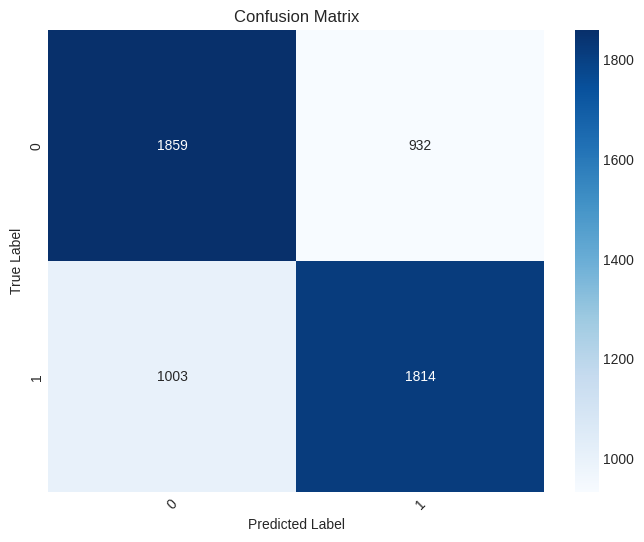

------------------------------------------------------------------------------------------------

Overall Metrics for Test set:
------------------------------------------------------------------------------------------------
Accuracy: 0.6947218259629101
Precision: 0.6948422152757624
Recall (TPR): 0.6947218259629101
False Positive Rate (FPR): 0.30525087942153606
F1 score (F-measure): 0.6947466788173897
Specificity: 0.6947491205784639
------------------------------------------------------------------------------------------------

Classwise Metrics for Test Set:


,Class,Accuracy,Precision,Recall (TPR),FPR,F1 Score (F-measure),TP,FP,TN,FN
0,0,0.694722,0.703125,0.693277,0.303779,0.698166,495,209,479,219
1,1,0.694722,0.686246,0.696221,0.306723,0.691198,479,219,495,209


------------------------------------------------------------------------------------------------
Confusion Matrix for Test Set
------------------------------------------------------------------------------------------------


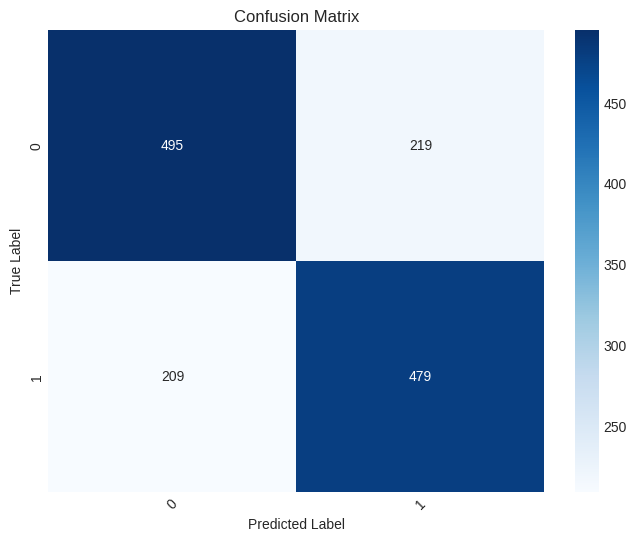

In [ ]:
print("Parameter tuned Logistic Regression performance for Selected Training and Testing dataset with 10-fold crossvalidation")
print("------------------------------------------------------------------------------------------------")
lr_result_2 = runclassifier(model_lr,X_train_selected_dnn_ga, y_train_dnn_ga,X_test_selected_dnn_ga, y_test_dnn_ga)

Logistic Regression performance for Selected Training and Testing dataset with 10-fold crossvalidation
------------------------------------------------------------------------------------------------
Overall Metrics for Training set:
------------------------------------------------------------------------------------------------
Accuracy: 0.6537089871611983
Precision: 0.6538257464149586
Recall (TPR): 0.6537089871611983
False Positive Rate (FPR): 0.34624554532565566
F1 score (F-measure): 0.6536822072753027
Specificity: 0.6537544546743443
------------------------------------------------------------------------------------------------

Classwise Metrics for Training Set:


,Class,Accuracy,Precision,Recall (TPR),FPR,F1 Score (F-measure),TP,FP,TN,FN
0,0,0.653709,0.648687,0.663561,0.356053,0.656040,1852,1003,1814,939
1,1,0.653709,0.658918,0.643947,0.336439,0.651346,1814,939,1852,1003


------------------------------------------------------------------------------------------------
Confusion Matrix for Train Set
------------------------------------------------------------------------------------------------


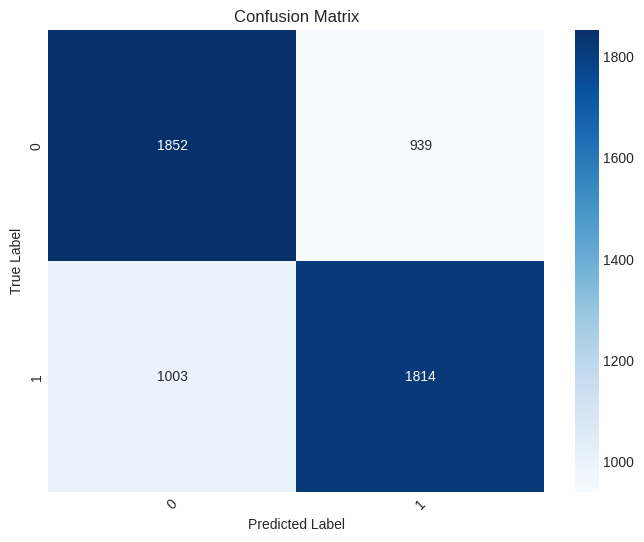

------------------------------------------------------------------------------------------------

Overall Metrics for Test set:
------------------------------------------------------------------------------------------------
Accuracy: 0.6897289586305279
Precision: 0.6896853350275705
Recall (TPR): 0.6897289586305279
False Positive Rate (FPR): 0.31052333724187353
F1 score (F-measure): 0.6896646688109099
Specificity: 0.6894766627581265
------------------------------------------------------------------------------------------------

Classwise Metrics for Test Set:


,Class,Accuracy,Precision,Recall (TPR),FPR,F1 Score (F-measure),TP,FP,TN,FN
0,0,0.689729,0.692414,0.703081,0.324128,0.697707,502,223,465,212
1,1,0.689729,0.686854,0.675872,0.296919,0.681319,465,212,502,223


------------------------------------------------------------------------------------------------
Confusion Matrix for Test Set
------------------------------------------------------------------------------------------------


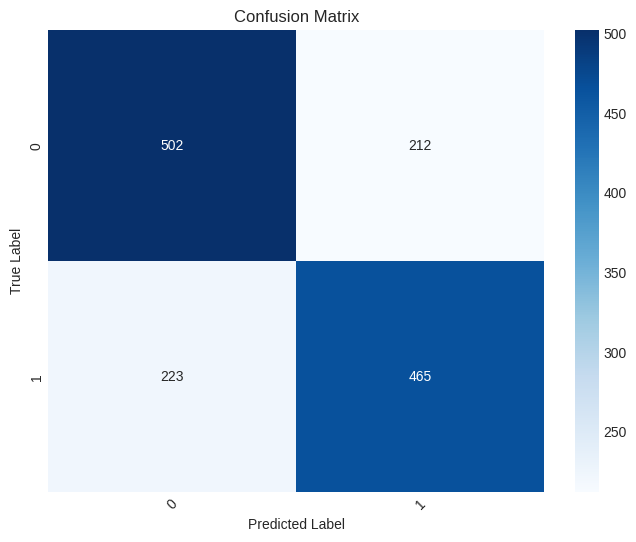

In [ ]:
print("Logistic Regression performance for Selected Training and Testing dataset with 10-fold crossvalidation")
print("------------------------------------------------------------------------------------------------")
model = LogisticRegression()
lr_result_3 = runclassifier(model,X_train_selected_dnn_ga, y_train_dnn_ga,X_test_selected_dnn_ga, y_test_dnn_ga)

Support Vector Machine

In [ ]:
def objective(trial):
    kernel = trial.suggest_categorical('kernel', ['poly','rbf','sigmoid'])
    C = trial.suggest_categorical('C', [50,10,1.0,0.1,0.01])
    gamma = trial.suggest_categorical('gamma',['scale'])
    model = SVC(kernel=kernel,C=C,gamma=gamma) # do not tune the seed
    model.fit(X_train_selected_dnn_ga, y_train_dnn_ga)
    y_pred = model.predict(X_test_selected_dnn_ga)
    return accuracy_score(y_test_dnn_ga, y_pred)

In [ ]:
sampler = TPESampler(seed=1)
study = optuna.create_study(direction="maximize", sampler=sampler)
study.optimize(objective, n_trials=100)

print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial
print("  Value: ", trial.value)
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2024-04-14 20:47:16,905] A new study created in memory with name: no-name-8a71bebf-1f04-4734-98ff-e0105253c9fa
[I 2024-04-14 20:47:21,975] Trial 0 finished with value: 0.6291012838801712 and parameters: {'kernel': 'rbf', 'C': 0.01, 'gamma': 'scale'}. Best is trial 0 with value: 0.6291012838801712.
[I 2024-04-14 20:47:27,086] Trial 1 finished with value: 0.6768901569186876 and parameters: {'kernel': 'rbf', 'C': 1.0, 'gamma': 'scale'}. Best is trial 1 with value: 0.6768901569186876.
[I 2024-04-14 20:47:32,145] Trial 2 finished with value: 0.6768901569186876 and parameters: {'kernel': 'rbf', 'C': 1.0, 'gamma': 'scale'}. Best is trial 1 with value: 0.6768901569186876.
[I 2024-04-14 20:47:36,196] Trial 3 finished with value: 0.6768901569186876 and parameters: {'kernel': 'rbf', 'C': 1.0, 'gamma': 'scale'}. Best is trial 1 with value: 0.6768901569186876.
[I 2024-04-14 20:47:39,223] Trial 4 finished with value: 0.6768901569186876 and parameters: {'kernel': 'poly', 'C': 1.0, 'gamma': 'scale'

Number of finished trials:  100
Best trial:
  Value:  0.7011412268188303
  Params: 
    kernel: poly
    C: 50
    gamma: scale


In [ ]:
model_svc = SVC(kernel='poly',C=50,gamma='scale', probability=True)

In [ ]:
filename = "DNN_NEW_svc_model.pkl"
pickle.dump(model_svc, open(filename, "wb"))

In [ ]:
with open('/content/drive/MyDrive/DNN_GA1/DNN_NEW_svc_model.pkl', 'rb') as f:
    model_svc = pickle.load(f)

Parameter Tuned Support Vector Machine performance for Selected Training and Testing dataset with 10-fold crossvalidation
------------------------------------------------------------------------------------------------
Overall Metrics for Training set:
------------------------------------------------------------------------------------------------
Accuracy: 0.671718972895863
Precision: 0.6720379979216338
Recall (TPR): 0.671718972895863
False Positive Rate (FPR): 0.32819796935914125
F1 score (F-measure): 0.6716245169055056
Specificity: 0.6718020306408587
------------------------------------------------------------------------------------------------

Classwise Metrics for Training Set:


,Class,Accuracy,Precision,Recall (TPR),FPR,F1 Score (F-measure),TP,FP,TN,FN
0,0,0.671719,0.663793,0.689717,0.346113,0.676507,1925,975,1842,866
1,1,0.671719,0.680207,0.653887,0.310283,0.666787,1842,866,1925,975


------------------------------------------------------------------------------------------------
Confusion Matrix for Train Set
------------------------------------------------------------------------------------------------


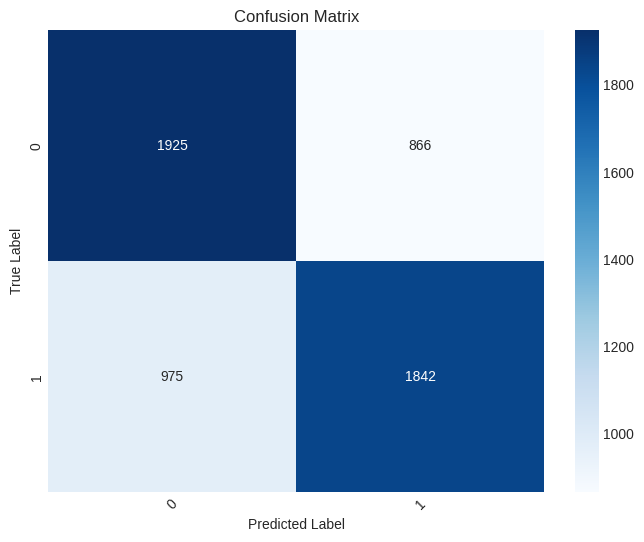

------------------------------------------------------------------------------------------------

Overall Metrics for Test set:
------------------------------------------------------------------------------------------------
Accuracy: 0.7011412268188303
Precision: 0.7011211813717368
Recall (TPR): 0.7011412268188303
False Positive Rate (FPR): 0.299001286561136
F1 score (F-measure): 0.7011279933075789
Specificity: 0.700998713438864
------------------------------------------------------------------------------------------------

Classwise Metrics for Test Set:


,Class,Accuracy,Precision,Recall (TPR),FPR,F1 Score (F-measure),TP,FP,TN,FN
0,0,0.701141,0.705718,0.708683,0.306686,0.707198,506,211,477,208
1,1,0.701141,0.696350,0.693314,0.291317,0.694829,477,208,506,211


------------------------------------------------------------------------------------------------
Confusion Matrix for Test Set
------------------------------------------------------------------------------------------------


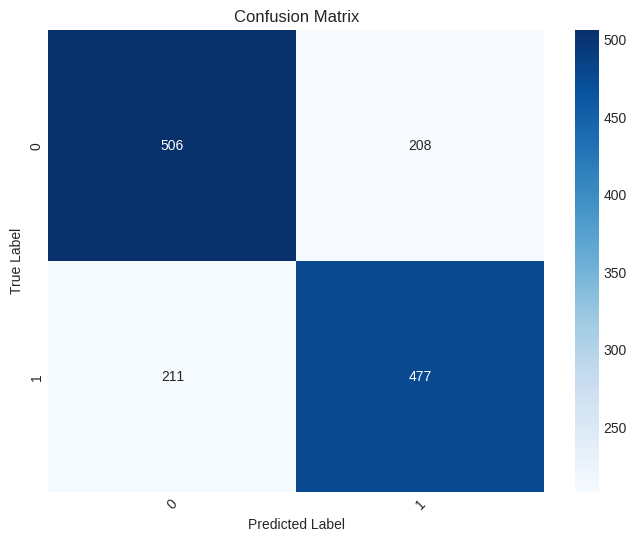

In [ ]:
print("Parameter Tuned Support Vector Machine performance for Selected Training and Testing dataset with 10-fold crossvalidation")
print("------------------------------------------------------------------------------------------------")
svc_result_2 = runclassifier(model_svc,X_train_selected_dnn_ga, y_train_dnn_ga,X_test_selected_dnn_ga, y_test_dnn_ga)

Support Vector Machine performance for Selected Training and Testing dataset with 10-fold crossvalidation
------------------------------------------------------------------------------------------------
Overall Metrics for Training set:
------------------------------------------------------------------------------------------------
Accuracy: 0.6562054208273894
Precision: 0.6565288390240902
Recall (TPR): 0.6562054208273894
False Positive Rate (FPR): 0.34370772121506743
F1 score (F-measure): 0.6560957281871734
Specificity: 0.6562922787849326
------------------------------------------------------------------------------------------------

Classwise Metrics for Training Set:


,Class,Accuracy,Precision,Recall (TPR),FPR,F1 Score (F-measure),TP,FP,TN,FN
0,0,0.656205,0.648537,0.675027,0.362442,0.661517,1884,1021,1796,907
1,1,0.656205,0.664447,0.637558,0.324973,0.650725,1796,907,1884,1021


------------------------------------------------------------------------------------------------
Confusion Matrix for Train Set
------------------------------------------------------------------------------------------------


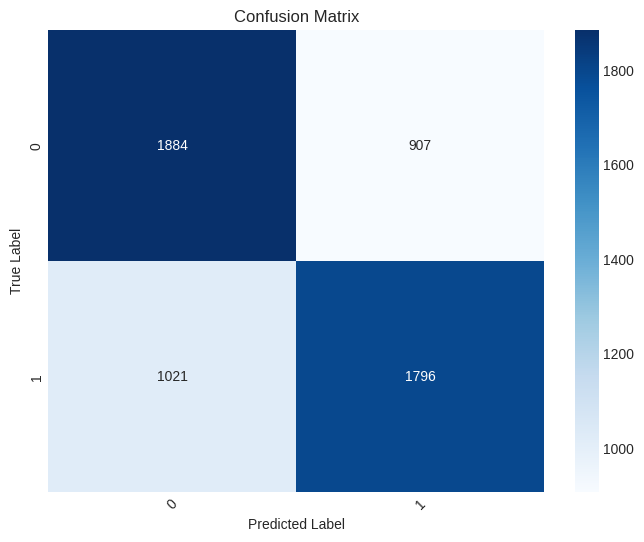

------------------------------------------------------------------------------------------------

Overall Metrics for Test set:
------------------------------------------------------------------------------------------------
Accuracy: 0.6768901569186876
Precision: 0.676842857020612
Recall (TPR): 0.6768901569186876
False Positive Rate (FPR): 0.32341948407269894
F1 score (F-measure): 0.6767889754805685
Specificity: 0.6765805159273011
------------------------------------------------------------------------------------------------

Classwise Metrics for Test Set:


,Class,Accuracy,Precision,Recall (TPR),FPR,F1 Score (F-measure),TP,FP,TN,FN
0,0,0.67689,0.679012,0.693277,0.340116,0.686071,495,234,454,219
1,1,0.67689,0.674591,0.659884,0.306723,0.667157,454,219,495,234


------------------------------------------------------------------------------------------------
Confusion Matrix for Test Set
------------------------------------------------------------------------------------------------


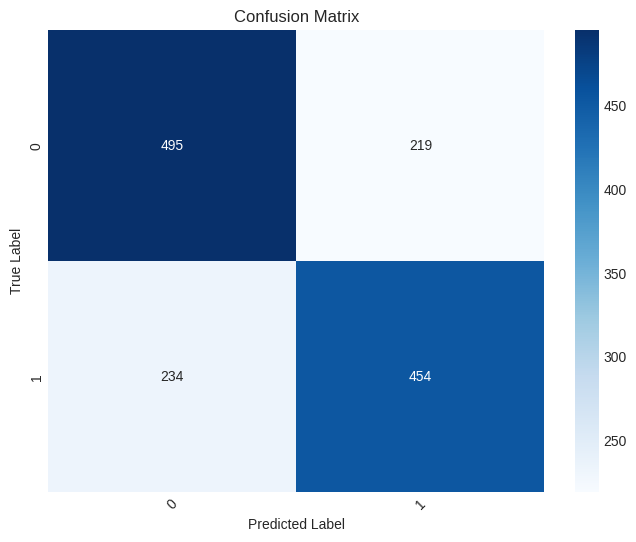

In [ ]:
print("Support Vector Machine performance for Selected Training and Testing dataset with 10-fold crossvalidation")
print("------------------------------------------------------------------------------------------------")
model = SVC(probability = True)
svc_result_3 = runclassifier(model,X_train_selected_dnn_ga, y_train_dnn_ga,X_test_selected_dnn_ga, y_test_dnn_ga)

DecisionTree

In [ ]:
def objective_dt(trial):
    max_depth = trial.suggest_int('max_depth', 3, 10)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 20)
    max_features = trial.suggest_categorical('max_features', ['auto', 'sqrt', 'log2'])
    model = DecisionTreeClassifier(max_depth=max_depth, min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf,max_features=max_features,random_state=1)
    model.fit(X_train_selected_dnn_ga, y_train_dnn_ga)
    y_pred = model.predict(X_test_selected_dnn_ga)
    return accuracy_score(y_test_dnn_ga, y_pred)

In [ ]:
sampler = TPESampler(seed=1)
study_dt = optuna.create_study(direction="maximize", sampler=sampler)
study_dt.optimize(objective_dt, n_trials=100)

print("Number of finished trials: ", len(study_dt.trials))
print("Best trial:")
trial = study_dt.best_trial
print("  Value: ", trial.value)
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2024-04-14 21:30:23,104] A new study created in memory with name: no-name-b4400069-e1f6-4014-9b18-c393a94522e0
[I 2024-04-14 21:30:23,136] Trial 0 finished with value: 0.6982881597717546 and parameters: {'max_depth': 6, 'min_samples_split': 15, 'min_samples_leaf': 1, 'max_features': 'auto'}. Best is trial 0 with value: 0.6982881597717546.
[I 2024-04-14 21:30:23,160] Trial 1 finished with value: 0.6704707560627675 and parameters: {'max_depth': 4, 'min_samples_split': 8, 'min_samples_leaf': 8, 'max_features': 'log2'}. Best is trial 0 with value: 0.6982881597717546.
[I 2024-04-14 21:30:23,184] Trial 2 finished with value: 0.651925820256776 and parameters: {'max_depth': 4, 'min_samples_split': 18, 'min_samples_leaf': 1, 'max_features': 'auto'}. Best is trial 0 with value: 0.6982881597717546.
[I 2024-04-14 21:30:23,209] Trial 3 finished with value: 0.651925820256776 and parameters: {'max_depth': 4, 'min_samples_split': 5, 'min_samples_leaf': 17, 'max_features': 'auto'}. Best is trial 0 w

Number of finished trials:  100
Best trial:
  Value:  0.7860199714693296
  Params: 
    max_depth: 10
    min_samples_split: 9
    min_samples_leaf: 3
    max_features: log2


In [ ]:
model_dt = DecisionTreeClassifier(max_depth=trial.params['max_depth'], min_samples_split=trial.params['min_samples_split'], min_samples_leaf=trial.params['min_samples_leaf'],max_features=trial.params['max_features'],random_state=1)

In [ ]:
model_dt = DecisionTreeClassifier(max_depth=10, min_samples_split=17, min_samples_leaf=2,max_features='auto',random_state=1)

In [ ]:
filename = "dnn_ga_dt_model.pkl"
pickle.dump(model_dt, open(filename, "wb"))

Parameter Tuned Support Vector Machine performance for Selected Training and Testing dataset with 10-fold crossvalidation
------------------------------------------------------------------------------------------------
Overall Metrics for Training set:
------------------------------------------------------------------------------------------------
Accuracy: 0.7475035663338089
Precision: 0.7481514174463767
Recall (TPR): 0.7475035663338089
False Positive Rate (FPR): 0.2526258714588845
F1 score (F-measure): 0.7472914026098244
Specificity: 0.7473741285411155
------------------------------------------------------------------------------------------------

Classwise Metrics for Training Set:


,Class,Accuracy,Precision,Recall (TPR),FPR,F1 Score (F-measure),TP,FP,TN,FN
0,0,0.747504,0.760318,0.719455,0.224707,0.739323,2008,633,2184,783
1,1,0.747504,0.736097,0.775293,0.280545,0.755187,2184,783,2008,633


------------------------------------------------------------------------------------------------
Confusion Matrix for Train Set
------------------------------------------------------------------------------------------------


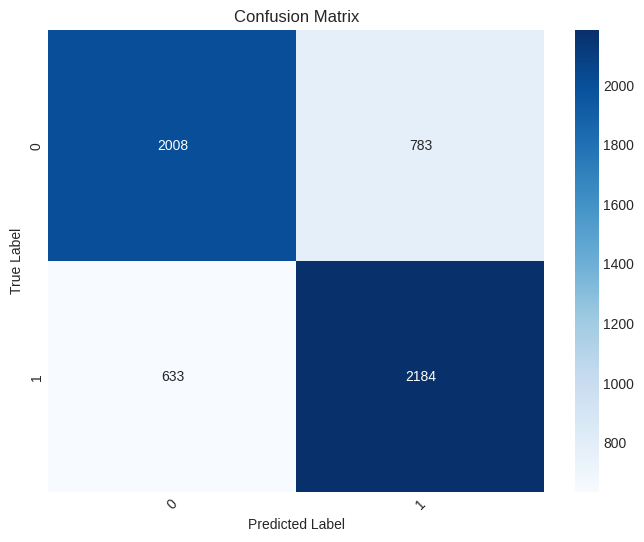

------------------------------------------------------------------------------------------------

Overall Metrics for Test set:
------------------------------------------------------------------------------------------------
Accuracy: 0.7860199714693296
Precision: 0.7878939987865089
Recall (TPR): 0.7860199714693296
False Positive Rate (FPR): 0.21336557878965534
F1 score (F-measure): 0.7858727391032717
Specificity: 0.7866344212103447
------------------------------------------------------------------------------------------------

Classwise Metrics for Test Set:


,Class,Accuracy,Precision,Recall (TPR),FPR,F1 Score (F-measure),TP,FP,TN,FN
0,0,0.78602,0.812689,0.753501,0.180233,0.781977,538,124,564,176
1,1,0.78602,0.762162,0.819767,0.246499,0.789916,564,176,538,124


------------------------------------------------------------------------------------------------
Confusion Matrix for Test Set
------------------------------------------------------------------------------------------------


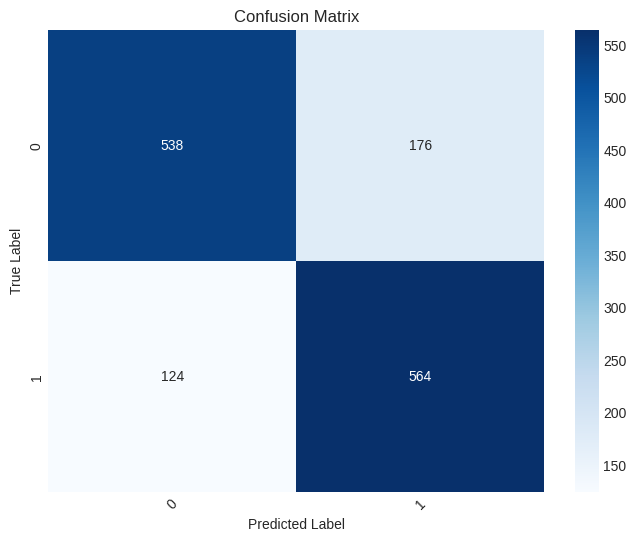

In [ ]:
print("Parameter Tuned Support Vector Machine performance for Selected Training and Testing dataset with 10-fold crossvalidation")
print("------------------------------------------------------------------------------------------------")
dt_result_2 = runclassifier(model_dt,X_train_selected_dnn_ga, y_train_dnn_ga,X_test_selected_dnn_ga, y_test_dnn_ga)

Decision Tree performance for Selected Training and Testing dataset with 10-fold crossvalidation
------------------------------------------------------------------------------------------------
Overall Metrics for Training set:
------------------------------------------------------------------------------------------------
Accuracy: 0.9042439372325249
Precision: 0.9152178140493993
Recall (TPR): 0.9042439372325249
False Positive Rate (FPR): 0.09613593925502473
F1 score (F-measure): 0.9035668460747358
Specificity: 0.9038640607449753
------------------------------------------------------------------------------------------------

Classwise Metrics for Training Set:


,Class,Accuracy,Precision,Recall (TPR),FPR,F1 Score (F-measure),TP,FP,TN,FN
0,0,0.904244,0.982862,0.821928,0.014200,0.895220,2294,40,2777,497
1,1,0.904244,0.848198,0.985800,0.178072,0.911837,2777,497,2294,40


------------------------------------------------------------------------------------------------
Confusion Matrix for Train Set
------------------------------------------------------------------------------------------------


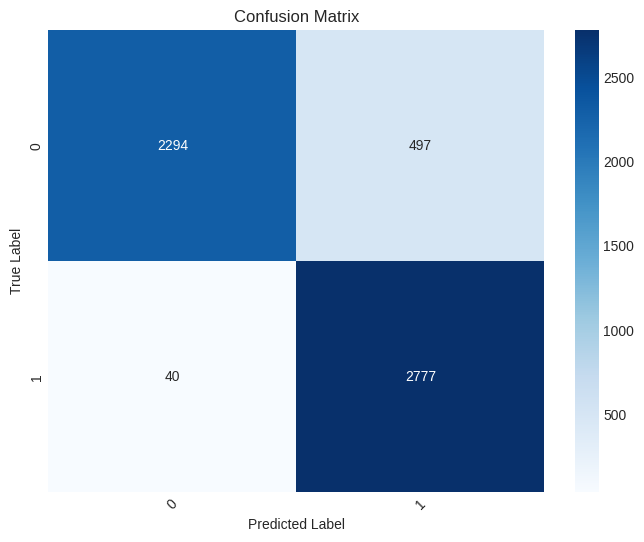

------------------------------------------------------------------------------------------------

Overall Metrics for Test set:
------------------------------------------------------------------------------------------------
Accuracy: 0.9122681883024251
Precision: 0.9234711781753532
Recall (TPR): 0.9122681883024251
False Positive Rate (FPR): 0.08626677415152106
F1 score (F-measure): 0.9118277000369963
Specificity: 0.9137332258484789
------------------------------------------------------------------------------------------------

Classwise Metrics for Test Set:


,Class,Accuracy,Precision,Recall (TPR),FPR,F1 Score (F-measure),TP,FP,TN,FN
0,0,0.912268,0.991681,0.834734,0.007267,0.906464,596,5,683,118
1,1,0.912268,0.852684,0.992733,0.165266,0.917394,683,118,596,5


------------------------------------------------------------------------------------------------
Confusion Matrix for Test Set
------------------------------------------------------------------------------------------------


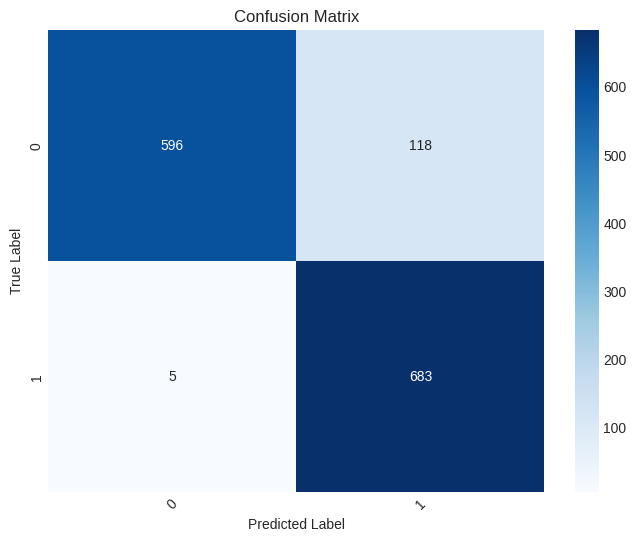

In [ ]:
print("Decision Tree performance for Selected Training and Testing dataset with 10-fold crossvalidation")
print("------------------------------------------------------------------------------------------------")
model = DecisionTreeClassifier()
dt_result_3 = runclassifier(model,X_train_selected_dnn_ga, y_train_dnn_ga,X_test_selected_dnn_ga, y_test_dnn_ga)

RandomForest Classifier

In [ ]:
def objective_rf(trial):
    n_estimators = trial.suggest_int("n_estimators", 50, 500)
    max_features  = trial.suggest_categorical("max_features", ['sqrt','log2'])
    criterion  = trial.suggest_categorical("criterion", ['gini','entropy'])
    max_depth = trial.suggest_int("max_depth", 1, 21)
    min_samples_split = trial.suggest_int("min_samples_split", 2, 11)
    min_samples_leaf = trial.suggest_categorical("min_samples_leaf", [1, 2, 4])
    max_leaf_nodes = trial.suggest_int("max_leaf_nodes", 2, 20)
    model = RandomForestClassifier(n_estimators=n_estimators, min_samples_leaf = min_samples_leaf, max_leaf_nodes= max_leaf_nodes,  min_samples_split=min_samples_split, criterion = criterion, max_features = max_features,  max_depth=max_depth, random_state=1)
    model.fit(X_train_selected_dnn_ga, y_train_dnn_ga)
    y_pred = model.predict(X_test_selected_dnn_ga)
    return accuracy_score(y_test_dnn_ga, y_pred)

In [ ]:
sampler = TPESampler(seed=1)
study_random = optuna.create_study(direction="maximize", sampler=sampler)
study_random.optimize(objective_rf, n_trials=100)

print("Number of finished trials: ", len(study_random.trials))
print("Best trial:")
trial_random = study_random.best_trial
print("  Value: ", trial_random.value)
print("  Params: ")
for key, value in trial_random.params.items():
    print("    {}: {}".format(key, value))

[I 2024-04-14 21:30:35,202] A new study created in memory with name: no-name-d64c381d-2b51-41f0-a122-83854eec016c
[I 2024-04-14 21:30:36,705] Trial 0 finished with value: 0.6690442225392297 and parameters: {'n_estimators': 238, 'max_features': 'sqrt', 'criterion': 'gini', 'max_depth': 2, 'min_samples_split': 3, 'min_samples_leaf': 4, 'max_leaf_nodes': 9}. Best is trial 0 with value: 0.6690442225392297.
[I 2024-04-14 21:30:41,280] Trial 1 finished with value: 0.723965763195435 and parameters: {'n_estimators': 359, 'max_features': 'log2', 'criterion': 'entropy', 'max_depth': 9, 'min_samples_split': 7, 'min_samples_leaf': 4, 'max_leaf_nodes': 20}. Best is trial 1 with value: 0.723965763195435.
[I 2024-04-14 21:30:42,022] Trial 2 finished with value: 0.6462196861626248 and parameters: {'n_estimators': 191, 'max_features': 'log2', 'criterion': 'gini', 'max_depth': 1, 'min_samples_split': 3, 'min_samples_leaf': 1, 'max_leaf_nodes': 20}. Best is trial 1 with value: 0.723965763195435.
[I 2024-

Number of finished trials:  100
Best trial:
  Value:  0.7368045649072753
  Params: 
    n_estimators: 422
    max_features: log2
    criterion: gini
    max_depth: 10
    min_samples_split: 4
    min_samples_leaf: 2
    max_leaf_nodes: 20


In [ ]:
model_rf = RandomForestClassifier(n_estimators=trial_random.params['n_estimators'], min_samples_leaf = trial_random.params['min_samples_leaf'], max_leaf_nodes= trial_random.params['max_leaf_nodes'],  min_samples_split=trial_random.params['min_samples_split'], criterion = trial_random.params['criterion'], max_features = trial_random.params['max_features'],  max_depth=trial_random.params['max_depth'], random_state=1)

In [ ]:
with open('rf_dnn_ga_results.pkl', 'wb') as f:
    pickle.dump(model_rf, f)

In [ ]:
with open('/content/drive/MyDrive/DNN_GA1/rf_dnn_ga_results.pkl', 'rb') as f:
    model_rf = pickle.load(f)

Parameter Tuned Random Forest performance for Selected Training and Testing dataset with 10-fold crossvalidation
------------------------------------------------------------------------------------------------
Overall Metrics for Training set:
------------------------------------------------------------------------------------------------
Accuracy: 0.7029243937232525
Precision: 0.7034043761244605
Recall (TPR): 0.7029243937232525
False Positive Rate (FPR): 0.29720269536177124
F1 score (F-measure): 0.7026869607623937
Specificity: 0.7027973046382288
------------------------------------------------------------------------------------------------

Classwise Metrics for Training Set:


,Class,Accuracy,Precision,Recall (TPR),FPR,F1 Score (F-measure),TP,FP,TN,FN
0,0,0.702924,0.712665,0.675385,0.269791,0.693525,1885,760,2057,906
1,1,0.702924,0.694229,0.730209,0.324615,0.711765,2057,906,1885,760


------------------------------------------------------------------------------------------------
Confusion Matrix for Train Set
------------------------------------------------------------------------------------------------


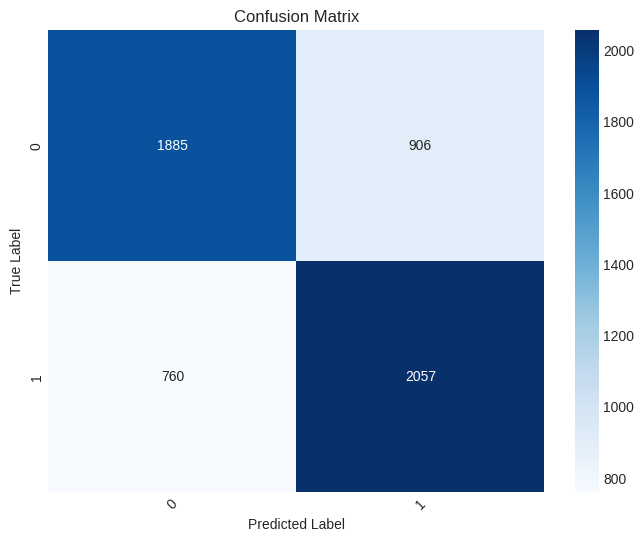

------------------------------------------------------------------------------------------------

Overall Metrics for Test set:
------------------------------------------------------------------------------------------------
Accuracy: 0.7368045649072753
Precision: 0.7383067394463975
Recall (TPR): 0.7368045649072753
False Positive Rate (FPR): 0.2626376131848087
F1 score (F-measure): 0.7366536183757946
Specificity: 0.7373623868151913
------------------------------------------------------------------------------------------------

Classwise Metrics for Test Set:


,Class,Accuracy,Precision,Recall (TPR),FPR,F1 Score (F-measure),TP,FP,TN,FN
0,0,0.736805,0.759398,0.707283,0.232558,0.732415,505,160,528,209
1,1,0.736805,0.716418,0.767442,0.292717,0.741053,528,209,505,160


------------------------------------------------------------------------------------------------
Confusion Matrix for Test Set
------------------------------------------------------------------------------------------------


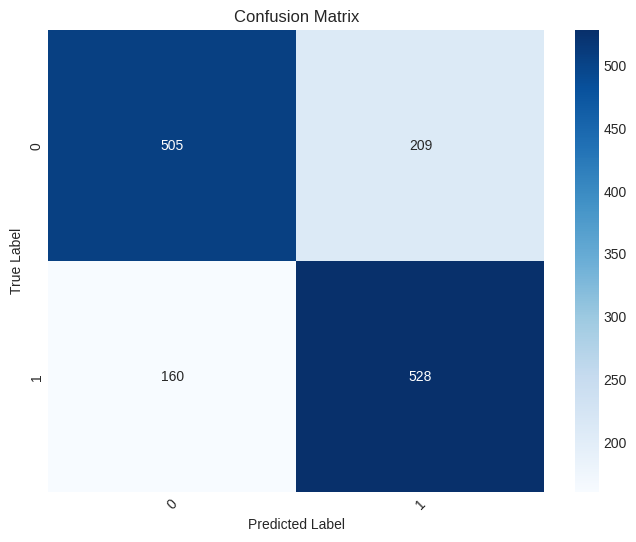

In [ ]:
print("Parameter Tuned Random Forest performance for Selected Training and Testing dataset with 10-fold crossvalidation")
print("------------------------------------------------------------------------------------------------")
rf_result_2 = runclassifier(model_rf,X_train_selected_dnn_ga, y_train_dnn_ga,X_test_selected_dnn_ga, y_test_dnn_ga)

Random Forest performance for Selected Training and Testing dataset with 10-fold crossvalidation
------------------------------------------------------------------------------------------------
Overall Metrics for Training set:
------------------------------------------------------------------------------------------------
Accuracy: 0.9634450784593438
Precision: 0.9642192801902213
Recall (TPR): 0.9634450784593438
False Positive Rate (FPR): 0.036650781894794204
F1 score (F-measure): 0.9634262193392289
Specificity: 0.9633492181052058
------------------------------------------------------------------------------------------------

Classwise Metrics for Training Set:


,Class,Accuracy,Precision,Recall (TPR),FPR,F1 Score (F-measure),TP,FP,TN,FN
0,0,0.963445,0.983184,0.942673,0.015974,0.962502,2631,45,2772,160
1,1,0.963445,0.945430,0.984026,0.057327,0.964342,2772,160,2631,45


------------------------------------------------------------------------------------------------
Confusion Matrix for Train Set
------------------------------------------------------------------------------------------------


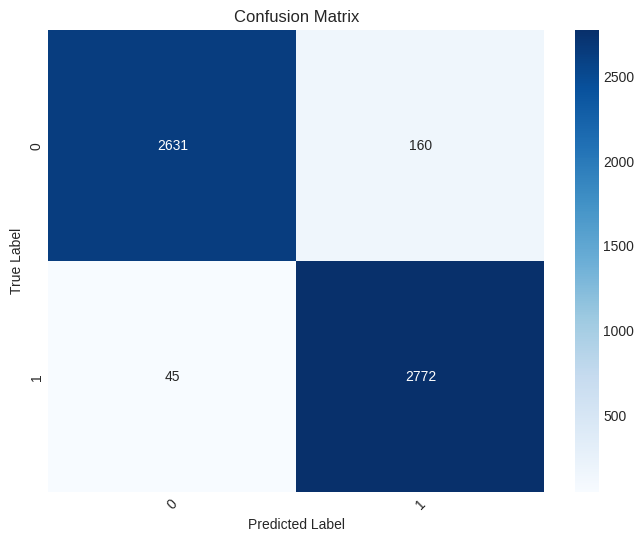

------------------------------------------------------------------------------------------------

Overall Metrics for Test set:
------------------------------------------------------------------------------------------------
Accuracy: 0.9686162624821684
Precision: 0.9697479066312075
Recall (TPR): 0.9686162624821684
False Positive Rate (FPR): 0.030944645299980422
F1 score (F-measure): 0.9686119194636568
Specificity: 0.9690553547000196
------------------------------------------------------------------------------------------------

Classwise Metrics for Test Set:


,Class,Accuracy,Precision,Recall (TPR),FPR,F1 Score (F-measure),TP,FP,TN,FN
0,0,0.968616,0.992647,0.945378,0.007267,0.968436,675,5,683,39
1,1,0.968616,0.945983,0.992733,0.054622,0.968794,683,39,675,5


------------------------------------------------------------------------------------------------
Confusion Matrix for Test Set
------------------------------------------------------------------------------------------------


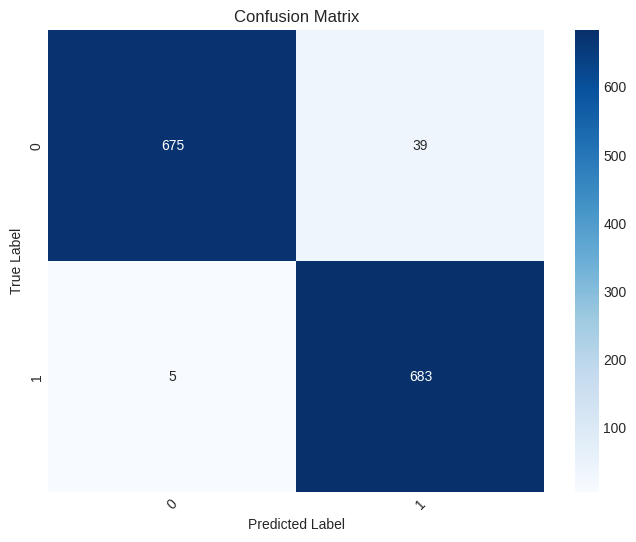

In [ ]:
print("Random Forest performance for Selected Training and Testing dataset with 10-fold crossvalidation")
print("------------------------------------------------------------------------------------------------")
model = RandomForestClassifier()
rf_result_3 = runclassifier(model,X_train_selected_dnn_ga, y_train_dnn_ga,X_test_selected_dnn_ga, y_test_dnn_ga)

XGBoost

In [ ]:
def objective_xgb(trial):
    n_estimators = trial.suggest_categorical("n_estimators",[180])
    reg_alpha = trial.suggest_int('reg_alpha', 1,9)
    reg_lambda = trial.suggest_int('reg_lambda', 0,1)
    colsample_bytree = trial.suggest_float('colsample_bytree', 0.5,1, log=True)
    max_depth = trial.suggest_int('max_depth', 3, 18, 1)
    min_child_weight= trial.suggest_int('min_child_weight', 0, 10, 1)
    learning_rate = trial.suggest_float("learning_rate", 0.001, 1.0, log=True)
    subsample = trial.suggest_int("subsample", 0.7, 1.0)
    model = XGBClassifier(n_estimators=n_estimators, reg_alpha = reg_alpha, reg_lambda = reg_lambda, colsample_bytree = colsample_bytree, max_depth = max_depth, min_child_weight = min_child_weight, learning_rate=learning_rate, random_state=1)
    model.fit(X_train_selected_dnn_ga, y_train_dnn_ga)
    y_pred = model.predict(X_test_selected_dnn_ga)
    return accuracy_score(y_test_dnn_ga, y_pred)

In [ ]:
sampler = TPESampler(seed=1)
study_xgb = optuna.create_study(direction="maximize", sampler=sampler)
study_xgb.optimize(objective_xgb, n_trials=100)

print("Number of finished trials: ", len(study_xgb.trials))
print("Best trial:")
trial = study_xgb.best_trial
print("  Value: ", trial.value)
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2024-04-14 21:39:18,806] A new study created in memory with name: no-name-dad71347-f5e8-4456-bfb9-060c0fe895bd
[I 2024-04-14 21:39:20,665] Trial 0 finished with value: 0.8017118402282454 and parameters: {'n_estimators': 180, 'reg_alpha': 4, 'reg_lambda': 1, 'colsample_bytree': 0.5000396408623998, 'max_depth': 7, 'min_child_weight': 1, 'learning_rate': 0.0018924123965722254, 'subsample': 0}. Best is trial 0 with value: 0.8017118402282454.
[I 2024-04-14 21:39:26,004] Trial 1 finished with value: 0.833095577746077 and parameters: {'n_estimators': 180, 'reg_alpha': 4, 'reg_lambda': 0, 'colsample_bytree': 0.7263902453474428, 'max_depth': 9, 'min_child_weight': 7, 'learning_rate': 0.004105412016858891, 'subsample': 1}. Best is trial 1 with value: 0.833095577746077.
[I 2024-04-14 21:39:31,985] Trial 2 finished with value: 0.920114122681883 and parameters: {'n_estimators': 180, 'reg_alpha': 1, 'reg_lambda': 1, 'colsample_bytree': 0.6677152068759228, 'max_depth': 11, 'min_child_weight': 1, '

Number of finished trials:  100
Best trial:
  Value:  0.9664764621968617
  Params: 
    n_estimators: 180
    reg_alpha: 1
    reg_lambda: 0
    colsample_bytree: 0.5587326929537195
    max_depth: 10
    min_child_weight: 2
    learning_rate: 0.0828492112049397
    subsample: 0


In [ ]:
model_xgb = XGBClassifier(n_estimators= trial.params['n_estimators'], reg_alpha = trial.params['reg_alpha'], reg_lambda = trial.params['reg_lambda'], colsample_bytree = trial.params['colsample_bytree'], max_depth = trial.params['max_depth'], min_child_weight = trial.params['min_child_weight'], learning_rate= trial.params['learning_rate'], random_state=1)

In [ ]:
with open('xgb_dnn_ga_results.pkl', 'wb') as f:
    pickle.dump(model_xgb, f)

In [ ]:
with open('/content/drive/MyDrive/DNN_GA1/xgb_dnn_ga_results.pkl', 'rb') as f:
    model_xgb = pickle.load(f)

Parameter Tuned XGBoost performance for Selected Training and Testing dataset with 10-fold crossvalidation
------------------------------------------------------------------------------------------------
Overall Metrics for Training set:
------------------------------------------------------------------------------------------------
Accuracy: 0.9497146932952925
Precision: 0.9517745410554144
Recall (TPR): 0.9497146932952925
False Positive Rate (FPR): 0.050443467370078765
F1 score (F-measure): 0.9496489763745708
Specificity: 0.9495565326299212
------------------------------------------------------------------------------------------------

Classwise Metrics for Training Set:


,Class,Accuracy,Precision,Recall (TPR),FPR,F1 Score (F-measure),TP,FP,TN,FN
0,0,0.949715,0.982314,0.915442,0.016329,0.94770,2555,46,2771,236
1,1,0.949715,0.921516,0.983671,0.084558,0.95158,2771,236,2555,46


------------------------------------------------------------------------------------------------
Confusion Matrix for Train Set
------------------------------------------------------------------------------------------------


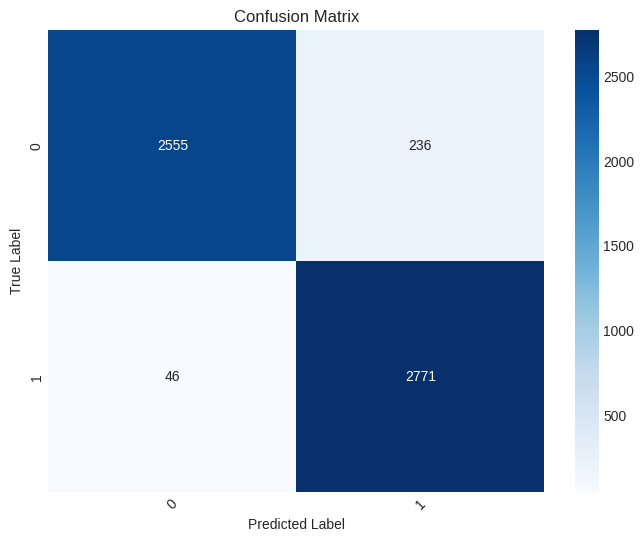

------------------------------------------------------------------------------------------------

Overall Metrics for Test set:
------------------------------------------------------------------------------------------------
Accuracy: 0.9664764621968617
Precision: 0.9678104021926458
Recall (TPR): 0.9664764621968617
False Positive Rate (FPR): 0.03304548563611487
F1 score (F-measure): 0.9664695203510731
Specificity: 0.9669545143638851
------------------------------------------------------------------------------------------------

Classwise Metrics for Test Set:


,Class,Accuracy,Precision,Recall (TPR),FPR,F1 Score (F-measure),TP,FP,TN,FN
0,0,0.966476,0.992614,0.941176,0.007267,0.966211,672,5,683,42
1,1,0.966476,0.942069,0.992733,0.058824,0.966737,683,42,672,5


------------------------------------------------------------------------------------------------
Confusion Matrix for Test Set
------------------------------------------------------------------------------------------------


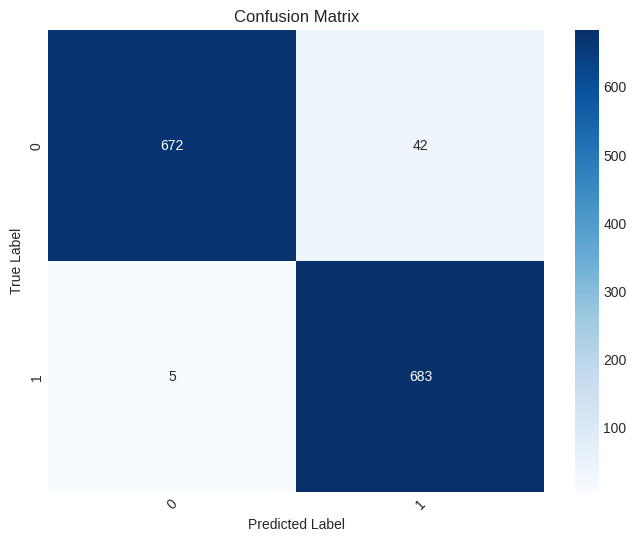

In [ ]:
print("Parameter Tuned XGBoost performance for Selected Training and Testing dataset with 10-fold crossvalidation")
print("------------------------------------------------------------------------------------------------")
xgb_result_2 = runclassifier(model_xgb,X_train_selected_dnn_ga, y_train_dnn_ga,X_test_selected_dnn_ga, y_test_dnn_ga)

XGBoost performance for Selected Training and Testing dataset with 10-fold crossvalidation
------------------------------------------------------------------------------------------------
Overall Metrics for Training set:
------------------------------------------------------------------------------------------------
Accuracy: 0.9379457917261056
Precision: 0.9415459907349628
Recall (TPR): 0.9379457917261056
False Positive Rate (FPR): 0.06226553299584703
F1 score (F-measure): 0.9378051121764247
Specificity: 0.937734467004153
------------------------------------------------------------------------------------------------

Classwise Metrics for Training Set:


,Class,Accuracy,Precision,Recall (TPR),FPR,F1 Score (F-measure),TP,FP,TN,FN
0,0,0.937946,0.981474,0.892153,0.016684,0.934685,2490,47,2770,301
1,1,0.937946,0.901986,0.983316,0.107847,0.940897,2770,301,2490,47


------------------------------------------------------------------------------------------------
Confusion Matrix for Train Set
------------------------------------------------------------------------------------------------


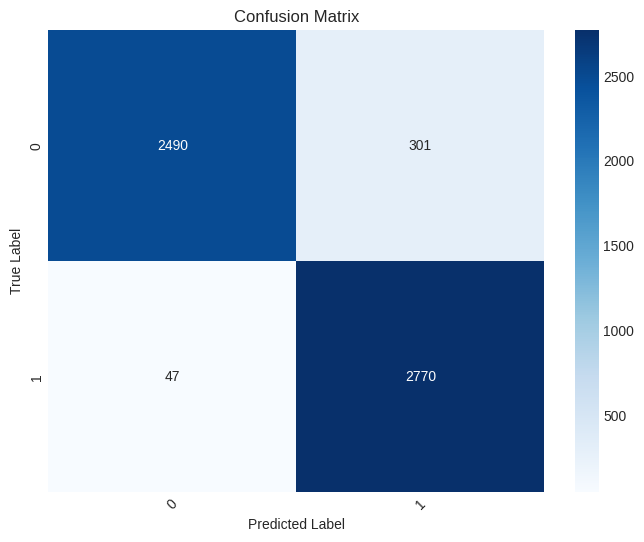

------------------------------------------------------------------------------------------------

Overall Metrics for Test set:
------------------------------------------------------------------------------------------------
Accuracy: 0.9514978601997147
Precision: 0.9546762126630993
Recall (TPR): 0.9514978601997147
False Positive Rate (FPR): 0.047751367989056104
F1 score (F-measure): 0.9514520387154943
Specificity: 0.9522486320109439
------------------------------------------------------------------------------------------------

Classwise Metrics for Test Set:


,Class,Accuracy,Precision,Recall (TPR),FPR,F1 Score (F-measure),TP,FP,TN,FN
0,0,0.951498,0.992378,0.911765,0.007267,0.950365,651,5,683,63
1,1,0.951498,0.915550,0.992733,0.088235,0.952580,683,63,651,5


------------------------------------------------------------------------------------------------
Confusion Matrix for Test Set
------------------------------------------------------------------------------------------------


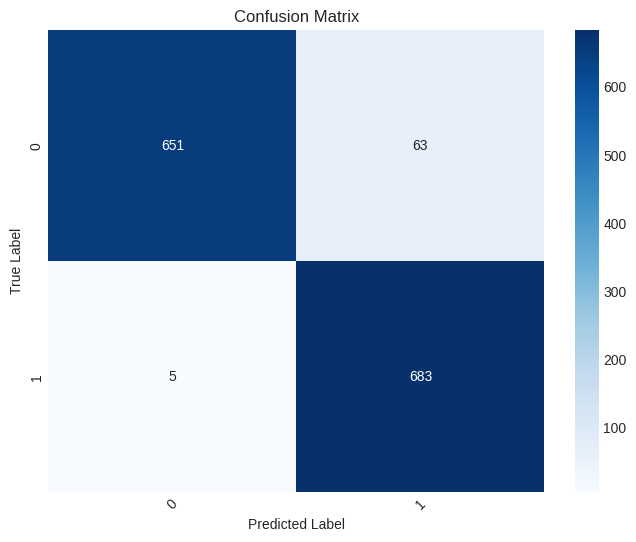

In [ ]:
print("XGBoost performance for Selected Training and Testing dataset with 10-fold crossvalidation")
print("------------------------------------------------------------------------------------------------")
model = XGBClassifier()
xgb_result_3 = runclassifier(model,X_train_selected_dnn_ga, y_train_dnn_ga,X_test_selected_dnn_ga, y_test_dnn_ga)

ExtraTrees

In [ ]:
from sklearn.ensemble import ExtraTreesClassifier

In [ ]:
def objective(trial):
    n_estimators = trial.suggest_int('n_estimators', 50, 120)
    max_depth = trial.suggest_int('max_depth', 10, 16)
    max_leaf_nodes = trial.suggest_int('max_leaf_nodes', 15, 25)
    criterion = trial.suggest_categorical('criterion', ['gini', 'entropy'])
    model = ExtraTreesClassifier(n_estimators = n_estimators,max_depth = max_depth,max_leaf_nodes = max_leaf_nodes,criterion = criterion, random_state = 1) # do not tune the seed
    model.fit(X_train_selected_dnn_ga, y_train_dnn_ga)
    y_pred = model.predict(X_test_selected_dnn_ga)
    return accuracy_score(y_test_dnn_ga, y_pred)

In [ ]:
sampler = TPESampler(seed=1)
study = optuna.create_study(direction="maximize", sampler=sampler)
study.optimize(objective, n_trials=100)

print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial
print("  Value: ", trial.value)
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2024-04-14 21:44:25,293] A new study created in memory with name: no-name-1b24147d-5a0a-41e0-97e2-fc4e60ce583c
[I 2024-04-14 21:44:25,568] Trial 0 finished with value: 0.6633380884450785 and parameters: {'n_estimators': 79, 'max_depth': 15, 'max_leaf_nodes': 15, 'criterion': 'gini'}. Best is trial 0 with value: 0.6633380884450785.
[I 2024-04-14 21:44:25,754] Trial 1 finished with value: 0.666904422253923 and parameters: {'n_estimators': 56, 'max_depth': 11, 'max_leaf_nodes': 18, 'criterion': 'entropy'}. Best is trial 1 with value: 0.666904422253923.
[I 2024-04-14 21:44:26,023] Trial 2 finished with value: 0.6683309557774608 and parameters: {'n_estimators': 79, 'max_depth': 14, 'max_leaf_nodes': 17, 'criterion': 'gini'}. Best is trial 2 with value: 0.6683309557774608.
[I 2024-04-14 21:44:26,372] Trial 3 finished with value: 0.6726105563480742 and parameters: {'n_estimators': 97, 'max_depth': 12, 'max_leaf_nodes': 21, 'criterion': 'entropy'}. Best is trial 3 with value: 0.672610556348

Number of finished trials:  100
Best trial:
  Value:  0.6825962910128388
  Params: 
    n_estimators: 90
    max_depth: 11
    max_leaf_nodes: 25
    criterion: entropy


In [ ]:
model_et = ExtraTreesClassifier(n_estimators = trial.params['n_estimators'],max_depth = trial.params['max_depth'],max_leaf_nodes = trial.params['max_leaf_nodes'],criterion = trial.params['criterion'], random_state = 1)

In [ ]:
with open('et_dnn_ga_results.pkl', 'wb') as f:
    pickle.dump(model_et, f)

In [ ]:
with open('/content/drive/MyDrive/DNN_GA1/et_dnn_ga_results.pkl', 'rb') as f:
    model_et = pickle.load(f)

Parameter Tuned ExtraTrees performance for Selected Training and Testing dataset with 10-fold crossvalidation
------------------------------------------------------------------------------------------------
Overall Metrics for Training set:
------------------------------------------------------------------------------------------------
Accuracy: 0.6594151212553495
Precision: 0.6601140609490119
Recall (TPR): 0.6594151212553495
False Positive Rate (FPR): 0.3404500011256324
F1 score (F-measure): 0.6591429858101446
Specificity: 0.6595499988743676
------------------------------------------------------------------------------------------------

Classwise Metrics for Training Set:


,Class,Accuracy,Precision,Recall (TPR),FPR,F1 Score (F-measure),TP,FP,TN,FN
0,0,0.659415,0.648667,0.688642,0.369542,0.668057,1922,1041,1776,869
1,1,0.659415,0.671456,0.630458,0.311358,0.650311,1776,869,1922,1041


------------------------------------------------------------------------------------------------
Confusion Matrix for Train Set
------------------------------------------------------------------------------------------------


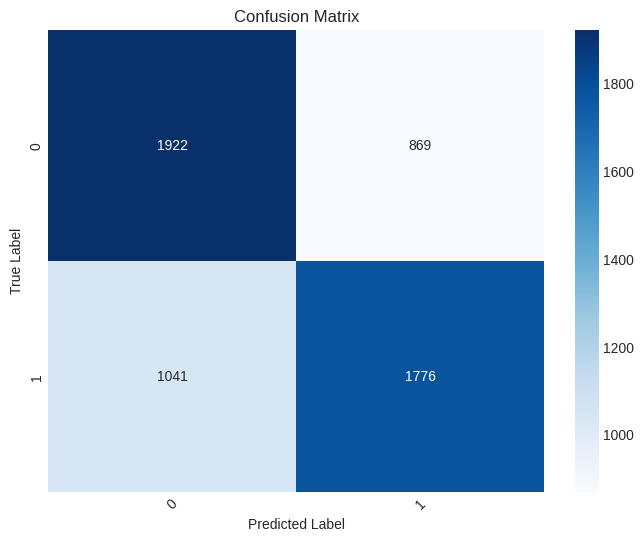

------------------------------------------------------------------------------------------------

Overall Metrics for Test set:
------------------------------------------------------------------------------------------------
Accuracy: 0.6825962910128388
Precision: 0.6827583483734474
Recall (TPR): 0.6825962910128388
False Positive Rate (FPR): 0.3179760276203505
F1 score (F-measure): 0.682250879528725
Specificity: 0.6820239723796495
------------------------------------------------------------------------------------------------

Classwise Metrics for Test Set:


,Class,Accuracy,Precision,Recall (TPR),FPR,F1 Score (F-measure),TP,FP,TN,FN
0,0,0.682596,0.679573,0.712885,0.348837,0.695830,509,240,448,205
1,1,0.682596,0.686064,0.651163,0.287115,0.668158,448,205,509,240


------------------------------------------------------------------------------------------------
Confusion Matrix for Test Set
------------------------------------------------------------------------------------------------


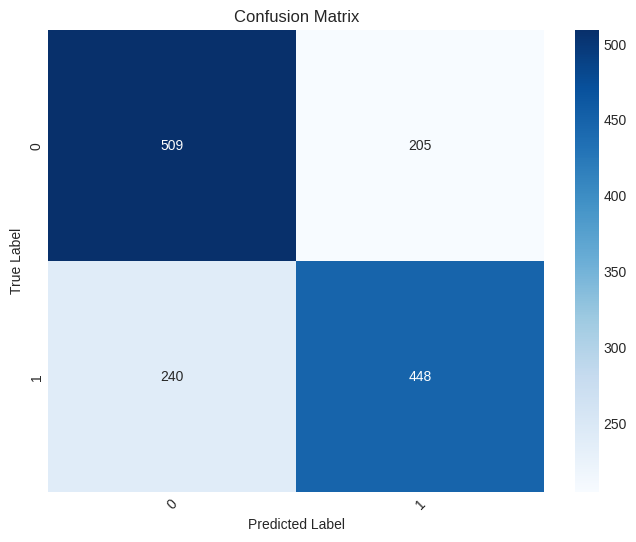

In [ ]:
print("Parameter Tuned ExtraTrees performance for Selected Training and Testing dataset with 10-fold crossvalidation")
print("------------------------------------------------------------------------------------------------")
et_result_1 = runclassifier(model_et,X_train_selected_dnn_ga, y_train_dnn_ga,X_test_selected_dnn_ga, y_test_dnn_ga)

Extra Trees performance for Selected Training and Testing dataset with 10-fold crossvalidation
------------------------------------------------------------------------------------------------
Overall Metrics for Training set:
------------------------------------------------------------------------------------------------
Accuracy: 0.9803851640513552
Precision: 0.9803888151323572
Recall (TPR): 0.9803851640513552
False Positive Rate (FPR): 0.019621871457358164
F1 score (F-measure): 0.9803849944014825
Specificity: 0.9803781285426418
------------------------------------------------------------------------------------------------

Classwise Metrics for Training Set:


,Class,Accuracy,Precision,Recall (TPR),FPR,F1 Score (F-measure),TP,FP,TN,FN
0,0,0.980385,0.981674,0.978861,0.018104,0.980266,2732,51,2766,59
1,1,0.980385,0.979115,0.981896,0.021139,0.980503,2766,59,2732,51


------------------------------------------------------------------------------------------------
Confusion Matrix for Train Set
------------------------------------------------------------------------------------------------


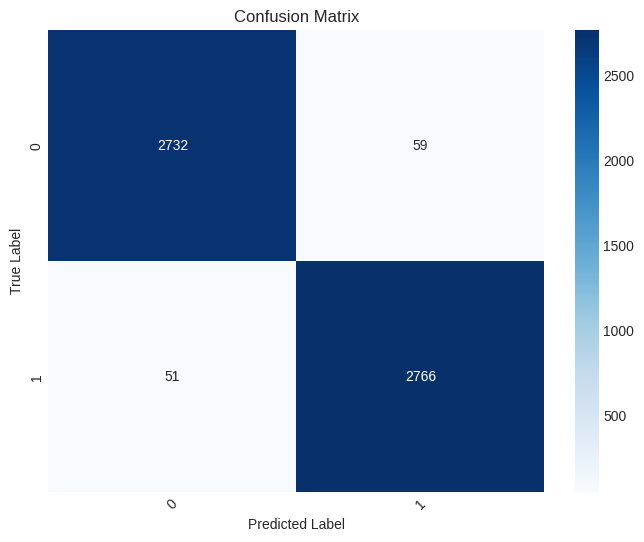

------------------------------------------------------------------------------------------------

Overall Metrics for Test set:
------------------------------------------------------------------------------------------------
Accuracy: 0.9864479315263909
Precision: 0.9865313444805207
Recall (TPR): 0.9864479315263909
False Positive Rate (FPR): 0.013437642498860036
F1 score (F-measure): 0.9864489865564885
Specificity: 0.98656235750114
------------------------------------------------------------------------------------------------

Classwise Metrics for Test Set:


,Class,Accuracy,Precision,Recall (TPR),FPR,F1 Score (F-measure),TP,FP,TN,FN
0,0,0.986448,0.992908,0.980392,0.007267,0.986610,700,5,683,14
1,1,0.986448,0.979914,0.992733,0.019608,0.986282,683,14,700,5


------------------------------------------------------------------------------------------------
Confusion Matrix for Test Set
------------------------------------------------------------------------------------------------


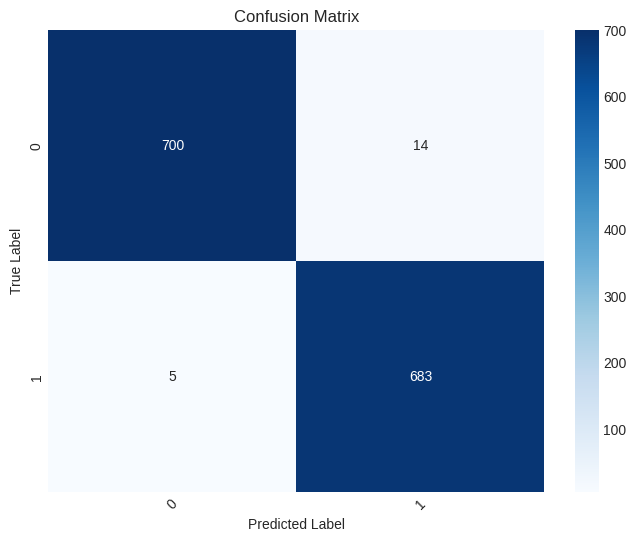

In [ ]:
print("Extra Trees performance for Selected Training and Testing dataset with 10-fold crossvalidation")
print("------------------------------------------------------------------------------------------------")
model = ExtraTreesClassifier()
et_dnn_result_2 = runclassifier(model,X_train_selected_dnn_ga, y_train_dnn_ga,X_test_selected_dnn_ga, y_test_dnn_ga)

AdaBoost Classifier

In [ ]:
def objective_adb(trial):
    n_estimators = trial.suggest_int("n_estimators", 50, 500)
    learning_rate = trial.suggest_float("learning_rate", 0.001, 1.0, log=True)
    model = AdaBoostClassifier(n_estimators=n_estimators, learning_rate=learning_rate, random_state=1)
    model.fit(X_train_selected_dnn_ga, y_train_dnn_ga)
    y_pred = model.predict(X_test_selected_dnn_ga)
    return accuracy_score(y_test_dnn_ga, y_pred)

In [ ]:
sampler = TPESampler(seed=1)
study_adb = optuna.create_study(direction="maximize", sampler=sampler)
study_adb.optimize(objective_adb, n_trials=100)

print("Number of finished trials: ", len(study_adb.trials))
print("Best trial:")
trial_adb = study_adb.best_trial
print("  Value: ", trial_adb.value)
print("  Params: ")
for key, value in trial_adb.params.items():
    print("    {}: {}".format(key, value))

[I 2024-04-14 21:45:14,819] A new study created in memory with name: no-name-af3e09a3-2fc8-4300-b7b8-72590641c2bf
[I 2024-04-14 21:45:21,270] Trial 0 finished with value: 0.7139800285306704 and parameters: {'n_estimators': 238, 'learning_rate': 0.14486833887239342}. Best is trial 0 with value: 0.7139800285306704.
[I 2024-04-14 21:45:22,409] Trial 1 finished with value: 0.6219686162624821 and parameters: {'n_estimators': 50, 'learning_rate': 0.008072307884499755}. Best is trial 0 with value: 0.7139800285306704.
[I 2024-04-14 21:45:25,018] Trial 2 finished with value: 0.6176890156918687 and parameters: {'n_estimators': 116, 'learning_rate': 0.0018924123965722254}. Best is trial 0 with value: 0.7139800285306704.
[I 2024-04-14 21:45:28,014] Trial 3 finished with value: 0.6476462196861626 and parameters: {'n_estimators': 134, 'learning_rate': 0.010881335003635882}. Best is trial 0 with value: 0.7139800285306704.
[I 2024-04-14 21:45:34,131] Trial 4 finished with value: 0.6768901569186876 and

Number of finished trials:  100
Best trial:
  Value:  0.8002853067047075
  Params: 
    n_estimators: 481
    learning_rate: 0.9772262851175356


In [ ]:
model_adb = AdaBoostClassifier(n_estimators=trial_adb.params["n_estimators"], learning_rate=trial_adb.params["learning_rate"], random_state=1)

In [ ]:
with open('adb_dnn_ga_results.pkl', 'wb') as f:
    pickle.dump(model_adb, f)

In [ ]:
with open('/content/drive/MyDrive/DNN_GA1/adb_dnn_ga_results.pkl', 'rb') as f:
    model_adb = pickle.load(f)

Parameter tuned AdaBoost performance for Selected Training and Testing dataset with 10-fold crossvalidation
------------------------------------------------------------------------------------------------
Overall Metrics for Training set:
------------------------------------------------------------------------------------------------
Accuracy: 0.7794222539229672
Precision: 0.7809077188731968
Recall (TPR): 0.7794222539229672
False Positive Rate (FPR): 0.2207552751776941
F1 score (F-measure): 0.7790771712795547
Specificity: 0.7792447248223059
------------------------------------------------------------------------------------------------

Classwise Metrics for Training Set:


,Class,Accuracy,Precision,Recall (TPR),FPR,F1 Score (F-measure),TP,FP,TN,FN
0,0,0.779422,0.800930,0.740953,0.182464,0.769775,2068,514,2303,723
1,1,0.779422,0.761071,0.817536,0.259047,0.788294,2303,723,2068,514


------------------------------------------------------------------------------------------------
Confusion Matrix for Train Set
------------------------------------------------------------------------------------------------


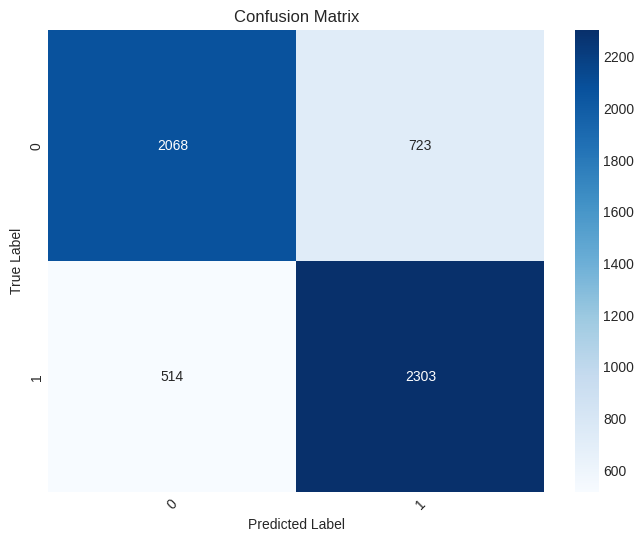

------------------------------------------------------------------------------------------------

Overall Metrics for Test set:
------------------------------------------------------------------------------------------------
Accuracy: 0.8002853067047075
Precision: 0.8036718305205515
Recall (TPR): 0.8002853067047075
False Positive Rate (FPR): 0.19885715914272684
F1 score (F-measure): 0.7999720555566777
Specificity: 0.8011428408572732
------------------------------------------------------------------------------------------------

Classwise Metrics for Test Set:


,Class,Accuracy,Precision,Recall (TPR),FPR,F1 Score (F-measure),TP,FP,TN,FN
0,0,0.800285,0.836957,0.754902,0.152616,0.793814,539,105,583,175
1,1,0.800285,0.769129,0.847384,0.245098,0.806362,583,175,539,105


------------------------------------------------------------------------------------------------
Confusion Matrix for Test Set
------------------------------------------------------------------------------------------------


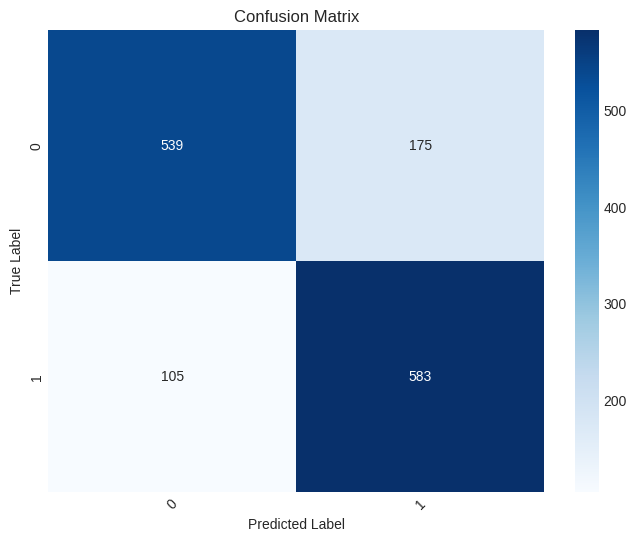

In [ ]:
print("Parameter tuned AdaBoost performance for Selected Training and Testing dataset with 10-fold crossvalidation")
print("------------------------------------------------------------------------------------------------")
adb_dnn_result_1 = runclassifier(model_adb,X_train_selected_dnn_ga, y_train_dnn_ga,X_test_selected_dnn_ga, y_test_dnn_ga)

AdaBoost performance for Selected Training and Testing dataset with 10-fold crossvalidation
------------------------------------------------------------------------------------------------
Overall Metrics for Training set:
------------------------------------------------------------------------------------------------
Accuracy: 0.6768901569186876
Precision: 0.6769854654833874
Recall (TPR): 0.6768901569186876
False Positive Rate (FPR): 0.32318127375036676
F1 score (F-measure): 0.6768067865914074
Specificity: 0.6768187262496332
------------------------------------------------------------------------------------------------

Classwise Metrics for Training Set:


,Class,Accuracy,Precision,Recall (TPR),FPR,F1 Score (F-measure),TP,FP,TN,FN
0,0,0.67689,0.680428,0.661412,0.307774,0.670785,1846,867,1950,945
1,1,0.67689,0.673575,0.692226,0.338588,0.682773,1950,945,1846,867


------------------------------------------------------------------------------------------------
Confusion Matrix for Train Set
------------------------------------------------------------------------------------------------


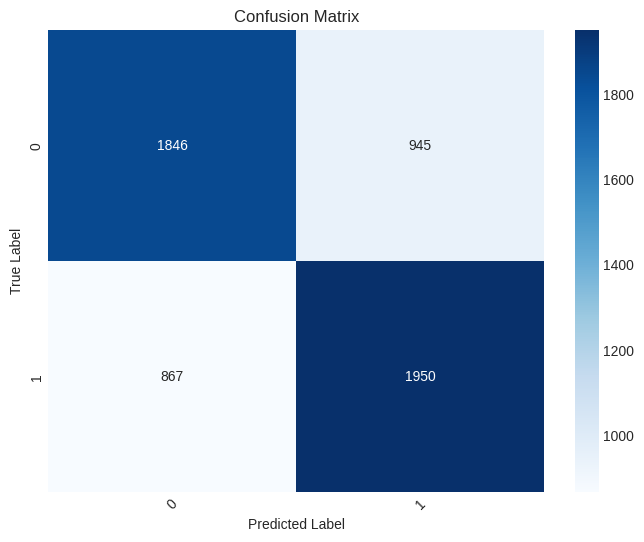

------------------------------------------------------------------------------------------------

Overall Metrics for Test set:
------------------------------------------------------------------------------------------------
Accuracy: 0.7161198288159771
Precision: 0.7168842690102386
Recall (TPR): 0.7161198288159771
False Positive Rate (FPR): 0.2835279460621458
F1 score (F-measure): 0.7160805442394425
Specificity: 0.7164720539378542
------------------------------------------------------------------------------------------------

Classwise Metrics for Test Set:


,Class,Accuracy,Precision,Recall (TPR),FPR,F1 Score (F-measure),TP,FP,TN,FN
0,0,0.71612,0.732353,0.697479,0.264535,0.714491,498,182,506,216
1,1,0.71612,0.700831,0.735465,0.302521,0.717730,506,216,498,182


------------------------------------------------------------------------------------------------
Confusion Matrix for Test Set
------------------------------------------------------------------------------------------------


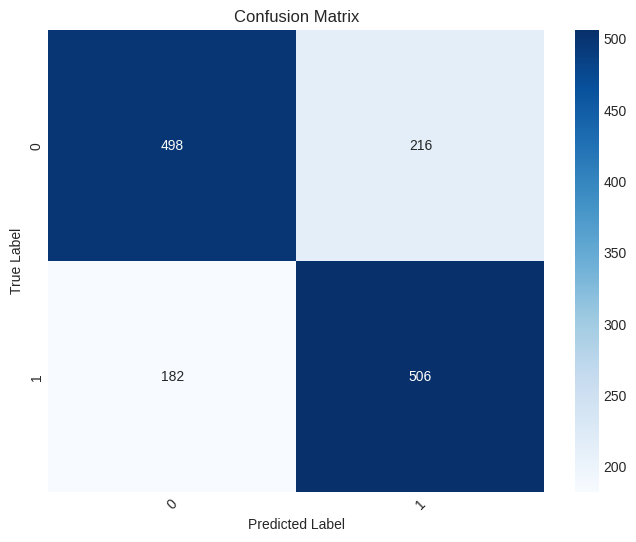

In [ ]:
print("AdaBoost performance for Selected Training and Testing dataset with 10-fold crossvalidation")
print("------------------------------------------------------------------------------------------------")
model = AdaBoostClassifier()
adb_dnn_result_2 = runclassifier(model,X_train_selected_dnn_ga, y_train_dnn_ga,X_test_selected_dnn_ga, y_test_dnn_ga)

Gradient Boosting Classifier

In [ ]:
def objective_gradient(trial):
    n_estimators = trial.suggest_int("n_estimators", 50, 500)
    learning_rate = trial.suggest_float("learning_rate", 0.001, 1.0, log=True)
    subsample = trial.suggest_float("subsample", 0.5, 1.0, log=True)
    max_depth = trial.suggest_int("max_depth", 1, 10)
    model = GradientBoostingClassifier(learning_rate=learning_rate, n_estimators=n_estimators, subsample=subsample, max_depth=max_depth, random_state=1)
    model.fit(X_train_selected_dnn_ga, y_train_dnn_ga)
    y_pred = model.predict(X_test_selected_dnn_ga)
    return accuracy_score(y_test_dnn_ga, y_pred)

In [ ]:
sampler = TPESampler(seed=1)
study_gradient = optuna.create_study(direction="maximize", sampler=sampler)
study_gradient.optimize(objective_gradient, n_trials=100)

print("Number of finished trials: ", len(study_gradient.trials))
print("Best trial:")
trial_gradient = study_gradient.best_trial
print("  Value: ", trial_gradient.value)
print("  Params: ")
for key, value in trial_gradient.params.items():
    print("    {}: {}".format(key, value))

[I 2024-04-14 22:03:34,053] A new study created in memory with name: no-name-08afdaa1-3e9d-4692-95d4-eee235840509
[I 2024-04-14 22:03:42,058] Trial 0 finished with value: 0.9386590584878745 and parameters: {'n_estimators': 238, 'learning_rate': 0.14486833887239342, 'subsample': 0.5000396408623998, 'max_depth': 4}. Best is trial 0 with value: 0.9386590584878745.
[I 2024-04-14 22:03:47,496] Trial 1 finished with value: 0.7082738944365192 and parameters: {'n_estimators': 116, 'learning_rate': 0.0018924123965722254, 'subsample': 0.5689052151487055, 'max_depth': 4}. Best is trial 0 with value: 0.9386590584878745.
[I 2024-04-14 22:04:04,797] Trial 2 finished with value: 0.9557774607703281 and parameters: {'n_estimators': 228, 'learning_rate': 0.04134759007834719, 'subsample': 0.6685903857355362, 'max_depth': 7}. Best is trial 2 with value: 0.9557774607703281.
[I 2024-04-14 22:04:13,476] Trial 3 finished with value: 0.9600570613409415 and parameters: {'n_estimators': 142, 'learning_rate': 0.4

Number of finished trials:  100
Best trial:
  Value:  0.9864479315263909
  Params: 
    n_estimators: 339
    learning_rate: 0.10930358066514531
    subsample: 0.7705005581160527
    max_depth: 10


In [ ]:
model_gradient =  GradientBoostingClassifier(n_estimators=trial_gradient.params["n_estimators"], learning_rate=trial_gradient.params["learning_rate"], subsample = trial_gradient.params['subsample'], max_depth = trial_gradient.params['max_depth'],random_state=1)

In [ ]:
filename = "dnn_ga_gradboost_model.pkl"
pickle.dump(model_gradient, open(filename, "wb"))

In [ ]:
with open('/content/drive/MyDrive/DNN_GA1/dnn_ga_gradboost_model.pkl', 'rb') as f:
    model_gradient = pickle.load(f)

Parameter Tuned GradientBoost performance for Selected Training and Testing dataset with 10-fold crossvalidation
------------------------------------------------------------------------------------------------
Overall Metrics for Training set:
------------------------------------------------------------------------------------------------
Accuracy: 0.9721825962910129
Precision: 0.9723820837701681
Recall (TPR): 0.9721825962910129
False Positive Rate (FPR): 0.02786595231617628
F1 score (F-measure): 0.9721782860127156
Specificity: 0.9721340476838237
------------------------------------------------------------------------------------------------

Classwise Metrics for Training Set:


,Class,Accuracy,Precision,Recall (TPR),FPR,F1 Score (F-measure),TP,FP,TN,FN
0,0,0.972183,0.982071,0.961662,0.017394,0.971760,2684,49,2768,107
1,1,0.972183,0.962783,0.982606,0.038338,0.972593,2768,107,2684,49


------------------------------------------------------------------------------------------------
Confusion Matrix for Train Set
------------------------------------------------------------------------------------------------


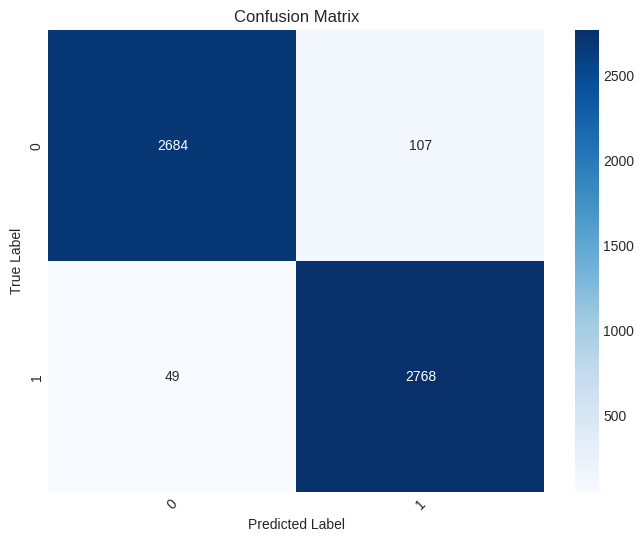

------------------------------------------------------------------------------------------------

Overall Metrics for Test set:
------------------------------------------------------------------------------------------------
Accuracy: 0.9864479315263909
Precision: 0.9865313444805207
Recall (TPR): 0.9864479315263909
False Positive Rate (FPR): 0.013437642498860036
F1 score (F-measure): 0.9864489865564885
Specificity: 0.98656235750114
------------------------------------------------------------------------------------------------

Classwise Metrics for Test Set:


,Class,Accuracy,Precision,Recall (TPR),FPR,F1 Score (F-measure),TP,FP,TN,FN
0,0,0.986448,0.992908,0.980392,0.007267,0.986610,700,5,683,14
1,1,0.986448,0.979914,0.992733,0.019608,0.986282,683,14,700,5


------------------------------------------------------------------------------------------------
Confusion Matrix for Test Set
------------------------------------------------------------------------------------------------


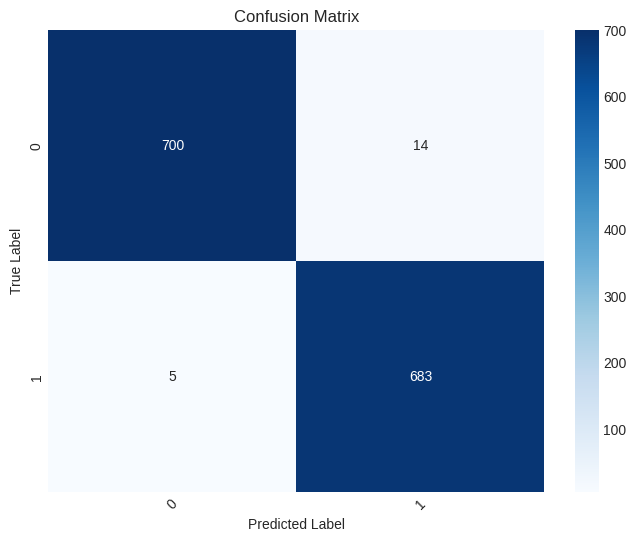

In [ ]:
print("Parameter Tuned GradientBoost performance for Selected Training and Testing dataset with 10-fold crossvalidation")
print("------------------------------------------------------------------------------------------------")
gradboost_dnn_result_1 = runclassifier(model_gradient,X_train_selected_dnn_ga, y_train_dnn_ga,X_test_selected_dnn_ga, y_test_dnn_ga)

GradientBoost performance for Selected Training and Testing dataset with 10-fold crossvalidation
------------------------------------------------------------------------------------------------
Overall Metrics for Training set:
------------------------------------------------------------------------------------------------
Accuracy: 0.7482168330955777
Precision: 0.748608144251938
Recall (TPR): 0.7482168330955777
False Positive Rate (FPR): 0.25188613382408365
F1 score (F-measure): 0.7480807069263351
Specificity: 0.7481138661759164
------------------------------------------------------------------------------------------------

Classwise Metrics for Training Set:


,Class,Accuracy,Precision,Recall (TPR),FPR,F1 Score (F-measure),TP,FP,TN,FN
0,0,0.748217,0.757950,0.725905,0.229677,0.741581,2026,647,2170,765
1,1,0.748217,0.739353,0.770323,0.274095,0.754520,2170,765,2026,647


------------------------------------------------------------------------------------------------
Confusion Matrix for Train Set
------------------------------------------------------------------------------------------------


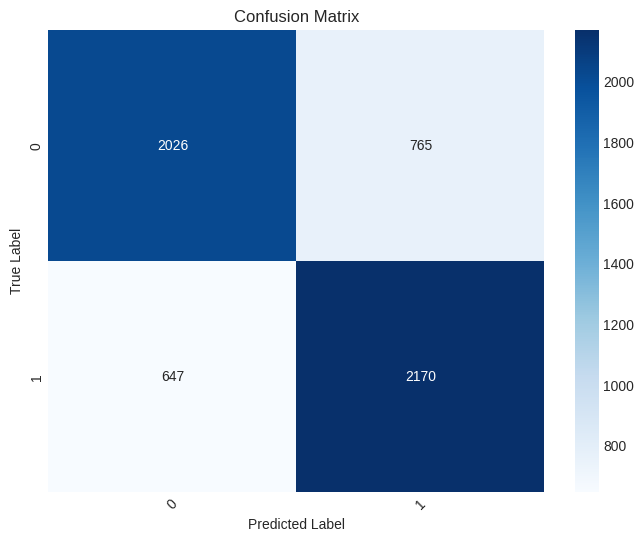

------------------------------------------------------------------------------------------------

Overall Metrics for Test set:
------------------------------------------------------------------------------------------------
Accuracy: 0.7767475035663338
Precision: 0.777738186158229
Recall (TPR): 0.7767475035663338
False Positive Rate (FPR): 0.22283971728226182
F1 score (F-measure): 0.7767012738273594
Specificity: 0.7771602827177382
------------------------------------------------------------------------------------------------

Classwise Metrics for Test Set:


,Class,Accuracy,Precision,Recall (TPR),FPR,F1 Score (F-measure),TP,FP,TN,FN
0,0,0.776748,0.796160,0.754902,0.200581,0.774982,539,138,550,175
1,1,0.776748,0.758621,0.799419,0.245098,0.778485,550,175,539,138


------------------------------------------------------------------------------------------------
Confusion Matrix for Test Set
------------------------------------------------------------------------------------------------


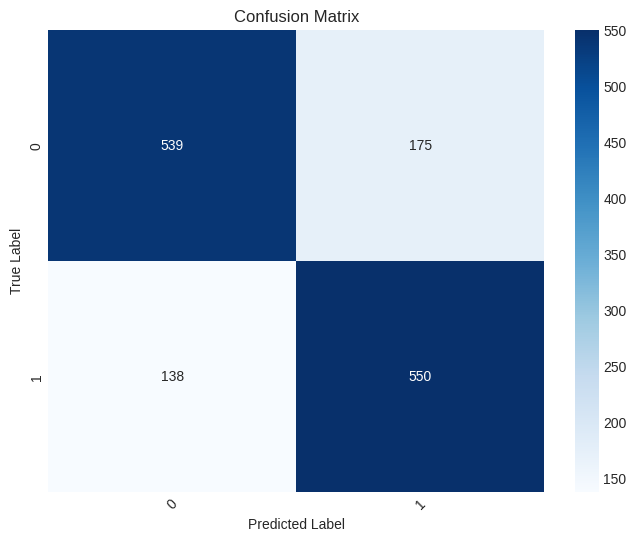

In [ ]:
print("GradientBoost performance for Selected Training and Testing dataset with 10-fold crossvalidation")
print("------------------------------------------------------------------------------------------------")
model = GradientBoostingClassifier()
gradboost_dnn_result_2 = runclassifier(model,X_train_selected_dnn_ga, y_train_dnn_ga,X_test_selected_dnn_ga, y_test_dnn_ga)

## Evaluation Results

In [ ]:
datasets_dnn = [
    (gb_result_1,"Initial"),
    (lr_result_1,"Initial"),
    (svc_result_1,"Initial"),
    (rf_result_1,"Initial"),
    (adb_result_1, "Initial"),
    (dt_result_1,"Initial"),
    (et_result_1,"Initial"),
    (xgb_result_1,"Initial"),
    (gradboost_result_1,"Initial"),
    (gb_result_2,"Proposed"),
    (lr_result_2,"Proposed"),
    (svc_result_2,"Proposed"),
    (rf_result_3,"Proposed"),
    (dt_result_3,"Proposed"),
    (et_dnn_result_2,"Proposed"),
    (adb_dnn_result_1, "Proposed"),
    (xgb_result_2,"Proposed"),
    (gradboost_dnn_result_1,"Proposed"),
]

In [ ]:
import pickle
with open('New_Results.pkl', 'wb') as f:
    pickle.dump(datasets_dnn, f)

In [65]:
with open('/content/drive/MyDrive/Kaggle/New_Results.pkl', 'rb') as f:
    datasets = pickle.load(f)

In [67]:
def extract_evaluation_metrics(d, metric_type):

    metrics = d[metric_type]
    # Check if TP, FP, TN, FN values are lists, and sum them to get scalar values
    TP = sum(metrics['TP']) if isinstance(metrics['TP'], (list, np.ndarray)) else metrics['TP']
    FP = sum(metrics['FP']) if isinstance(metrics['FP'], (list, np.ndarray)) else metrics['FP']
    TN = sum(metrics['TN']) if isinstance(metrics['TN'], (list, np.ndarray)) else metrics['TN']
    FN = sum(metrics['FN']) if isinstance(metrics['FN'], (list, np.ndarray)) else metrics['FN']

    return [ # Return all the metrics stored in the result dictionary
        d['Model'],
        metrics['Accuracy'],
        metrics['Precision'],
        metrics['Recall'],
        metrics['F1 score'],
        TP,
        FP,
        TN,
        FN,
        metrics['Sensitivity (TPR)'],
        metrics['Specificity'],
        metrics['FPR']
    ]

In [66]:
# defining dataframe to store the results for training and testing metrics for each classifier according to the neural network
training_results_dnn = pd.DataFrame({
    'Model': [],
    'Accuracy': [],
    'Precision': [],
    'Recall': [],
    'F1 score': [],
    'True Positive': [],
    'False Positive': [],
    'True Negative': [],
    'False Negative': [],
    'Sensitivity (TPR)': [],
    'Specificity': [],
    'False Positive Rate':[],
    'Approach': [], # define a new variable to specify which dataset does the result belong to
})

testing_results_dnn = pd.DataFrame({
    'Model': [],
    'Accuracy': [],
    'Precision': [],
    'Recall': [],
    'F1 score': [],
    'True Positive': [],
    'False Positive': [],
    'True Negative': [],
    'False Negative': [],
    'Sensitivity (TPR)': [],
    'Specificity': [],
    'False Positive Rate':[],
    'Approach': [], # define a new variable
})


In [70]:
for d, data_val in datasets:
    training_results_dnn.loc[len(training_results_dnn.index)] = extract_evaluation_metrics(d, "Training Metrics")+ [data_val]
    testing_results_dnn.loc[len(testing_results_dnn.index)] = extract_evaluation_metrics(d, "Test Metrics")+ [data_val]

In [71]:
def combine_metrics(df):
    # Combine all metrics into a single column
    df_combined = pd.melt(df, id_vars=['Model', 'Approach'], value_vars=[
        'Accuracy', 'Precision', 'Recall', 'F1 score',
        'Sensitivity (TPR)', 'Specificity', 'False Positive Rate'
    ], var_name='Metric', value_name='Value')
    return df_combined

def plot_metrics(df, title):
    plt.figure(figsize=(12, 6))
    sns.barplot(x='Approach', y='Value', hue='Model', data=df, palette='viridis', ci=None)
    plt.title(title)
    plt.ylabel('Value')
    plt.xticks(rotation=45)

    # Place legend outside the plot
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()

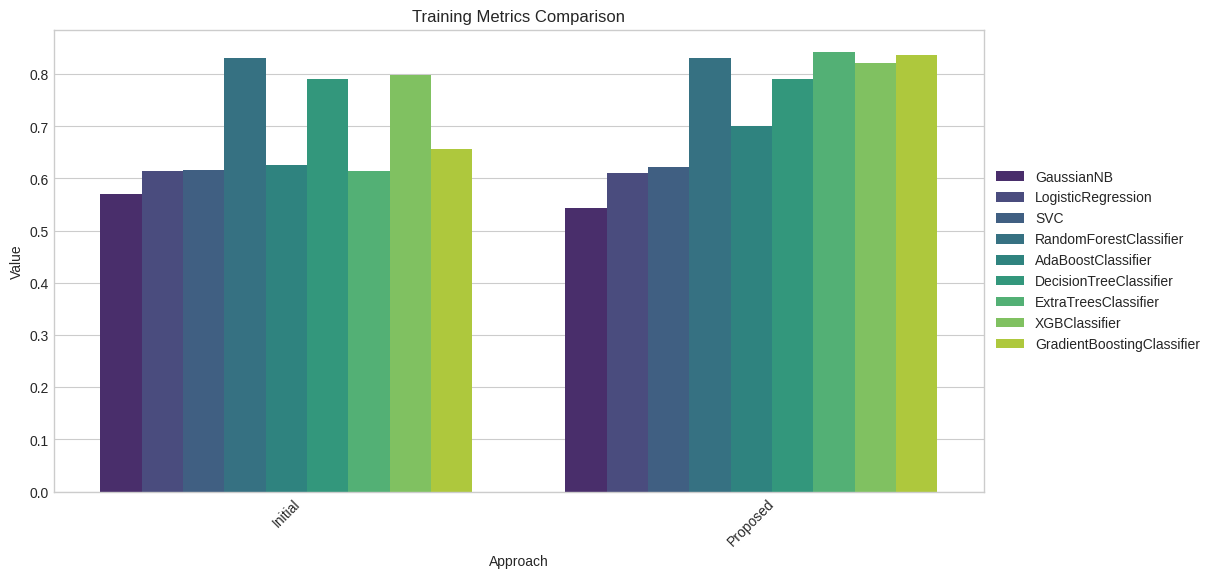

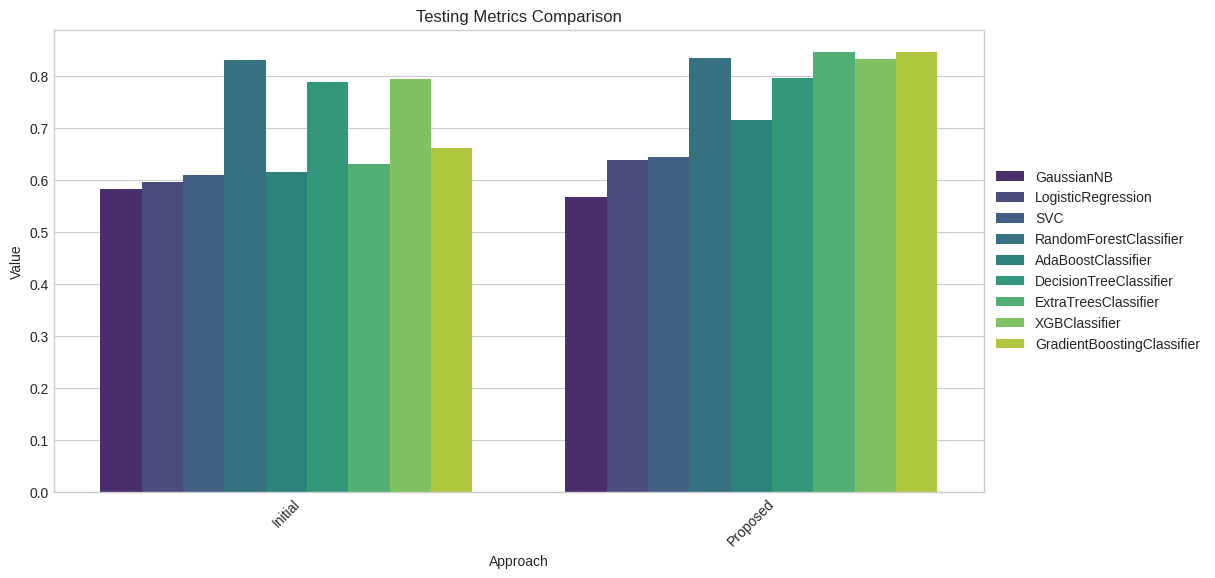

In [72]:
# Combine metrics for training and testing results
training_results_combined_dnn = combine_metrics(training_results_dnn)
testing_results_combined_dnn = combine_metrics(testing_results_dnn)

# Plot all metrics for training and testing
plot_metrics(training_results_combined_dnn, 'Training Metrics Comparison')
plot_metrics(testing_results_combined_dnn, 'Testing Metrics Comparison')

In [76]:
training_results_dnn_acc = training_results_dnn.sort_values(by='Accuracy', ascending=False)
# Select the top 9 unique models
top_models_training_dnn_acc = training_results_dnn_acc.drop_duplicates(subset='Model').head(9)
top_models_training_dnn_acc

,Model,Accuracy,Precision,Recall,F1 score,True Positive,False Positive,True Negative,False Negative,Sensitivity (TPR),Specificity,False Positive Rate,Approach
15,ExtraTreesClassifier,0.980385,0.980389,0.980385,0.980385,5498,110,5498,110,0.980385,0.980378,0.019622,Proposed
18,GradientBoostingClassifier,0.972183,0.972382,0.972183,0.972178,5452,156,5452,156,0.972183,0.972134,0.027866,Proposed
13,RandomForestClassifier,0.963445,0.964219,0.963445,0.963426,5403,205,5403,205,0.963445,0.963349,0.036651,Proposed
17,XGBClassifier,0.949715,0.951775,0.949715,0.949649,5326,282,5326,282,0.949715,0.949557,0.050443,Proposed
14,DecisionTreeClassifier,0.904244,0.915218,0.904244,0.903567,5071,537,5071,537,0.904244,0.903864,0.096136,Proposed
16,AdaBoostClassifier,0.779422,0.780908,0.779422,0.779077,4371,1237,4371,1237,0.779422,0.779245,0.220755,Proposed
12,SVC,0.671719,0.672038,0.671719,0.671625,3767,1841,3767,1841,0.671719,0.671802,0.328198,Proposed
2,LogisticRegression,0.660128,0.660137,0.660128,0.660024,3702,1906,3702,1906,0.660128,0.659945,0.340055,Initial
1,GaussianNB,0.593973,0.651373,0.593973,0.554824,3331,2277,3331,2277,0.593973,0.597269,0.402731,Initial


In [75]:
testing_results_dnn_acc = testing_results_dnn.sort_values(by='Accuracy', ascending=False)

# Select the top 8 unique models
top_models_testing_dnn_acc = testing_results_dnn_acc.drop_duplicates(subset='Model').head(9)

top_models_testing_dnn_acc

,Model,Accuracy,Precision,Recall,F1 score,True Positive,False Positive,True Negative,False Negative,Sensitivity (TPR),Specificity,False Positive Rate,Approach
17,GradientBoostingClassifier,0.986448,0.986531,0.986448,0.986449,1383,19,1383,19,0.986448,0.986562,0.013438,Proposed
14,ExtraTreesClassifier,0.986448,0.986531,0.986448,0.986449,1383,19,1383,19,0.986448,0.986562,0.013438,Proposed
12,RandomForestClassifier,0.968616,0.969748,0.968616,0.968612,1358,44,1358,44,0.968616,0.969055,0.030945,Proposed
16,XGBClassifier,0.966476,0.967810,0.966476,0.966470,1355,47,1355,47,0.966476,0.966955,0.033045,Proposed
13,DecisionTreeClassifier,0.912268,0.923471,0.912268,0.911828,1279,123,1279,123,0.912268,0.913733,0.086267,Proposed
15,AdaBoostClassifier,0.800285,0.803672,0.800285,0.799972,1122,280,1122,280,0.800285,0.801143,0.198857,Proposed
11,SVC,0.701141,0.701121,0.701141,0.701128,983,419,983,419,0.701141,0.700999,0.299001,Proposed
10,LogisticRegression,0.694722,0.694842,0.694722,0.694747,974,428,974,428,0.694722,0.694749,0.305251,Proposed
0,GaussianNB,0.616262,0.659255,0.616262,0.577038,864,538,864,538,0.616262,0.603058,0.396942,Initial
